# FDS Data

### Imports

In [1]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime

In [2]:
gen_palette = sns.color_palette(["#e41a1c", "#000000"])  # red & black
sns.set_palette(gen_palette)

## Cleaning

In [3]:
fds = pd.read_csv('data/fds.csv')
fds.head()

,Random Identifier,Recipient Primary Major,Recipient Secondary Majors,Recipient Graduation Date,Recipient Primary College,Recipient Graduation Group Name,Response Date,Outcome,Employer Name,Employer Industry,...,Other Compensation,Knowledge Response?,922242: Did you participate in a Work Based Experience while attending UIndy?,"922243: Please list the name of the employer(s) / organization(s) for which you participated in Experiential Learning. (Skip this question if you answered ""None of the Above"" to the previous question.)",922244: Do you feel like the Professional Edge Center helped you prepare for your career?,FTPT,CAMPUS_RESD,RESIDENCY,SEX,SPORT_1
0,100,Business Administration & Management,NaN,May 2023,BN,May 2023 - Undergrad,5/1/2023,Seeking employment,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Full-Time,On-Campus,International,F,NaN
1,101,Chemistry,BIOL,May 2023,AS,May 2023 - Undergrad,4/18/2023,Employed full time (on average 30 hours or mor...,Roche,Science & Technology,...,NaN,NaN,NaN,NaN,NaN,Full-Time,Off-Campus,Resident,F,NaN
2,102,Communication,NaN,May 2023,AS,May 2023 - Undergrad,4/13/2023,Seeking employment,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Full-Time,Off-Campus,Resident,F,NaN
3,103,Criminal Justice,SOC,May 2023,AS,May 2023 - Undergrad,4/25/2023,Employed full time (on average 30 hours or mor...,Credence Innovations,Sales and Marketing,...,NaN,NaN,NaN,NaN,NaN,Full-Time,Off-Campus,Resident,M,NaN
4,104,Exercise Science,NaN,May 2023,CH,May 2023 - Undergrad,4/25/2023,Pursuing or furthering education (Graduate/Pro...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Full-Time,On-Campus,Resident,F,NaN


In [4]:
def clean(x):
    if pd.isnull(x):
        return np.nan
    # x = x.replace('-', ' ')
    index = x.find("(")
    if index != -1:
        return x[:index].lower().strip()
    return x.lower().strip()

In [5]:

def get_term(date_str):
    """
    Robustly classify a date string into 'Winter', 'Summer', or 'Fall'
    based on a school schedule (Winter = Jan–May, Summer = Jun–Aug, Fall = Sep–Dec).
    Handles formats like 'May 2023', 'may 23', '06/15/24', etc.
    """

    # Normalize spacing and capitalization
    if pd.isnull(date_str):
                return np.nan
    date_str = date_str.strip()

    try:
        # dateutil automatically parses many formats
        date = parser.parse(date_str, fuzzy=True, default=datetime(2000, 1, 1))
    except Exception:
        raise ValueError(f"Unrecognized date format: {date_str}")

    month = date.month
    year = date.year

    # Assign terms
    if 1 <= month <= 5:
        season = "Winter"
    elif 6 <= month <= 8:
        season = "Summer"
    else:
        season = "Fall"

    return f"{season} {year}"

In [6]:
mappings = pd.read_csv('data/mapping.csv').map(clean)
mappings = pd.Series(mappings["CODE"].values, index=mappings["MAJOR MINOR OR CONCENTRATION"]).to_dict()
print(mappings)

{'accounting/non-cpa track': 'aact', 'business administration': 'badm', 'accounting': 'acct', 'chemistry': 'chem', 'communication': 'gcom', 'corrections': 'corr', 'accounting/cpa track': 'acpa', 'computer science': 'gcsc', 'actuarial science': 'acts', 'applied data analytics': 'msda', 'addiction counseling': 'addc', 'design': 'des', 'emergency/disaster mgmt': 'edm', 'ms aging studies/otd': 'aedt', 'aging studies ms/mot': 'aemt', 'english': 'engl', 'district admin: exceptnl needs': 'aexn', 'acad career explore': 'aexp', 'adult gero acute care/np': 'agac', 'aging stud.': 'aghc', 'aging stds': 'agha', 'adult gero np/primary care': 'agns', 'certificate in aging studies': 'agst', 'aging studies': 'asph', 'health sciences': 'ahlt', 'hospitality management': 'ahos', 'grad cert/american history': 'ahst', 'hotel and tourism mgt': 'htmg', 'information systems': 'is', 'is/applied bus analytics': 'isa', 'law enforcement': 'law', 'life sciences': 'life', 'adult learning & talent dev': 'altd', 'mana

In [7]:
school_map = pd.read_csv('data/school_map.csv')
school_map = school_map.map(clean)
school_map = pd.Series(school_map["CODE"].values, index=school_map["SCHOOL"]).to_dict()
print(school_map)

{'school of education': 'ed', 'college of arts & sciences': 'as', 'school of business': 'bn', nan: 'bh', 'college of health sciences': 'ch', 'school of nursing': 'nu', 'college of education and behavioral sciences': 'eb', 'shaheen college of arts & sciences': 'as'}


In [8]:
def map_to_abb(major):
    if pd.isna(major):
        return np.nan
    major = major.lower().strip()
    pattern = r'\(([^()]*)\)(?!.*\([^()]*\))'
    paren_match = re.search(pattern, major)
    if paren_match:
        return paren_match.group(1).upper()
    else:
        if major in mappings:
            return mappings[major].upper()
        else:
            return major.upper()


In [9]:
def school_to_code(school):
    if pd.isna(school):
        return np.nan
    school = school.lower().strip()
    if school in school_map:
        return school_map[school].upper()
    else:
        return school.upper()

In [10]:
fds["Recipient Primary Major"].unique()

array(['Business Administration & Management', 'Chemistry',
       'Communication', 'Criminal Justice', 'Exercise Science',
       'Anthropology', 'Human Biology', 'Marketing', 'Nursing',
       'Psychology', 'Physical Therapist Assistant',
       'Respiratory Therapy', 'Finance', 'Political Science',
       'Accounting', 'English/Literary Studies',
       'Operations & Supply Chain Mgt', 'Music Teaching (K-12)',
       'Environmental Sustainability', 'Art', 'Sociology',
       'Sport Management', 'Public Health Edu & Promotion', 'Music',
       'General Studies', 'Pre-Art Therapy', 'Organizational Leadership',
       'Mathematics', 'Elementary Education', 'Biology',
       'Social Work (BSW)', 'Computer Science', 'Religion',
       'Mechanical Engineering', 'Industrial & Systm Engineering',
       'Studio Art', 'Music Performance', 'Is/Applied Bus Analytics',
       'Music Therapy', 'Environmental Science',
       'Community Non-Profit Leadership', 'Earth-Space Science',
       'Engli

In [11]:
mapped = fds["Recipient Primary Major"].map(map_to_abb)
mapped[mapped.str.len() > 5].unique()

array(['ENGLISH/PROFESSIONAL WRITING'], dtype=object)

In [12]:
mapped = fds["Recipient Primary College"].map(school_to_code)
mapped[mapped.str.len() > 2].unique()

array(['COLLEGE OF APP. BEHAVIORAL SCI'], dtype=object)

In [ ]:
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

In [43]:
clean = fds.copy()
clean["Recipient Primary Major"] = clean["Recipient Primary Major"].map(map_to_abb)
clean["Recipient Secondary Majors"] = clean["Recipient Secondary Majors"].map(map_to_abb)
clean["Recipient Primary College"] = clean["Recipient Primary College"].map(school_to_code)
clean["Recipient Graduation Date"] = clean["Recipient Graduation Date"].map(get_term)
clean["Outcome Category"] = clean["Outcome"].map(categorize_outcome)
clean.head()

,Random Identifier,Recipient Primary Major,Recipient Secondary Majors,Recipient Graduation Date,Recipient Primary College,Recipient Graduation Group Name,Response Date,Outcome,Employer Name,Employer Industry,...,Knowledge Response?,922242: Did you participate in a Work Based Experience while attending UIndy?,"922243: Please list the name of the employer(s) / organization(s) for which you participated in Experiential Learning. (Skip this question if you answered ""None of the Above"" to the previous question.)",922244: Do you feel like the Professional Edge Center helped you prepare for your career?,FTPT,CAMPUS_RESD,RESIDENCY,SEX,SPORT_1,Outcome Category
0,100,BMGT,NaN,Winter 2023,BN,May 2023 - Undergrad,5/1/2023,Seeking employment,NaN,NaN,...,NaN,NaN,NaN,NaN,Full-Time,On-Campus,International,F,NaN,Negative
1,101,CHEM,BIOL,Winter 2023,AS,May 2023 - Undergrad,4/18/2023,Employed full time (on average 30 hours or mor...,Roche,Science & Technology,...,NaN,NaN,NaN,NaN,Full-Time,Off-Campus,Resident,F,NaN,Positive
2,102,GCOM,NaN,Winter 2023,AS,May 2023 - Undergrad,4/13/2023,Seeking employment,NaN,NaN,...,NaN,NaN,NaN,NaN,Full-Time,Off-Campus,Resident,F,NaN,Negative
3,103,CRIM,SOC,Winter 2023,AS,May 2023 - Undergrad,4/25/2023,Employed full time (on average 30 hours or mor...,Credence Innovations,Sales and Marketing,...,NaN,NaN,NaN,NaN,Full-Time,Off-Campus,Resident,M,NaN,Positive
4,104,MEXS,NaN,Winter 2023,CH,May 2023 - Undergrad,4/25/2023,Pursuing or furthering education (Graduate/Pro...,NaN,NaN,...,NaN,NaN,NaN,NaN,Full-Time,On-Campus,Resident,F,NaN,Inconclusive


In [44]:
clean.to_csv('data/clean.csv', index=False)

In [15]:
clean.columns

Index(['Random Identifier', 'Recipient Primary Major',
       'Recipient Secondary Majors', 'Recipient Graduation Date',
       'Recipient Primary College', 'Recipient Graduation Group Name',
       'Response Date', 'Outcome', 'Employer Name', 'Employer Industry',
       'Employment Type', 'Job Function', 'Job Position',
       'Found through Handshake', 'Employed During Education', 'Internship',
       'Continuing Education School', 'Continuing Education Level',
       'Continuing Education Major', 'Still Looking Option',
       'Not Seeking Option', 'Location', 'Offer Date', 'Accept Date',
       'Start Date', 'Annual Salary', 'Pay Schedule', 'Bonus Amount',
       'Other Compensation', 'Knowledge Response?',
       '922242: Did you participate in a Work Based Experience while attending UIndy?',
       '922243: Please list the name of the employer(s) / organization(s) for which you participated in Experiential Learning.  (Skip this question if you answered "None of the Above" to the 


### Graduation Date

# EDA

## Majors

In [16]:
clean["Recipient Primary Major"].unique()

array(['BMGT', 'CHEM', 'GCOM', 'CRIM', 'MEXS', 'GANT', 'HBIO', 'MKTG',
       'NUTA', 'PSYM', 'PTA', 'RESP', 'FIN', 'PSCI', 'ACCT', 'ENLS',
       'SCM', 'K-12', 'SUST', 'GART', 'SOCA', 'SMGT', 'PHEP', 'MUS',
       'GENS', 'ARTH', 'ORGL', 'MATH', 'ELM2', 'GBIO', 'BSW', 'GCSC',
       'REL', 'MENG', 'ISEN', 'SART', 'MUPR', 'ISA', 'MTPY', 'ENSC',
       'CNPA', 'ESCI', 'ENCW', 'GARC', 'DES', 'HIST', 'SWEN', 'SPAN',
       'THE', 'LBST', 'IRMA', 'IS', 'ENGLISH/PROFESSIONAL WRITING',
       'MKTS', 'EXD', 'VCD', 'ACTS', 'GENE', 'SLD', 'EENG', 'ENTR',
       'CMPE', 'MLSC', 'MUSJ', 'PHIL', 'SED2', 'DATA'], dtype=object)

In [17]:
top_5_majors = clean["Recipient Primary Major"].value_counts().nlargest(5)
print(top_5_majors)

Recipient Primary Major
NUTA    230
PSYM    192
MEXS    127
BMGT    118
FIN      78
Name: count, dtype: int64


Text(0.5, 1.0, 'Recipient Primary Major')

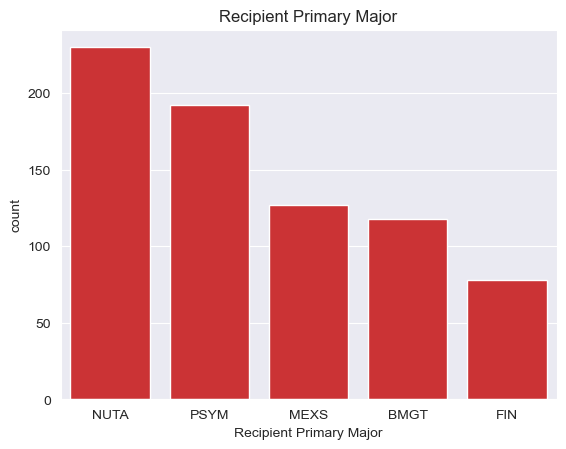

In [18]:
# By semester
ax = sns.barplot(top_5_majors)
ax.set_title("Recipient Primary Major")

In [19]:
clean["Recipient Graduation Date"].unique()

array(['Winter 2023', 'Winter 2025', 'Winter 2024', 'Summer 2023',
       'Fall 2024', 'Fall 2023', 'Summer 2024', nan, 'Winter 2027',
       'Summer 2025'], dtype=object)

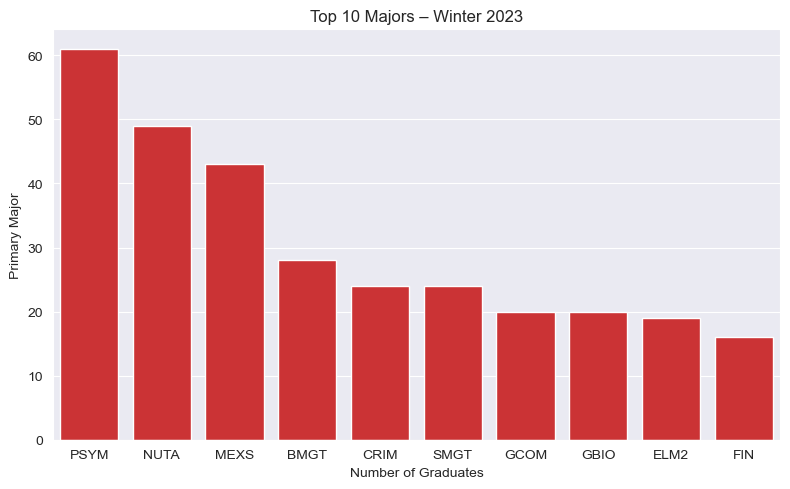

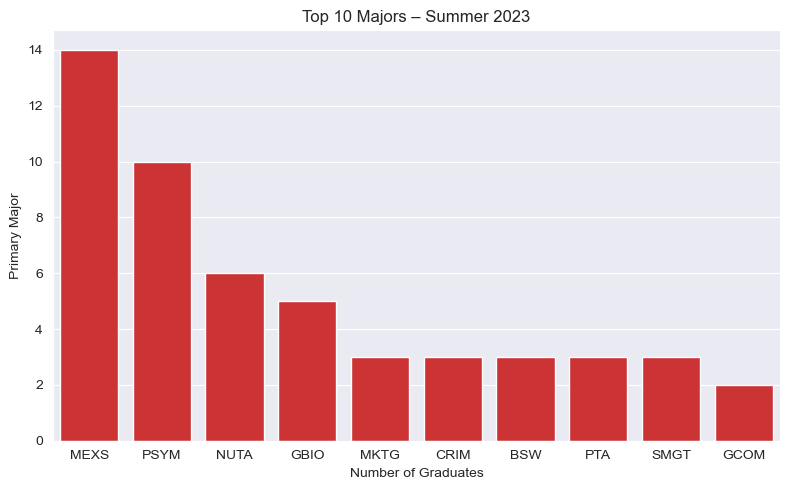

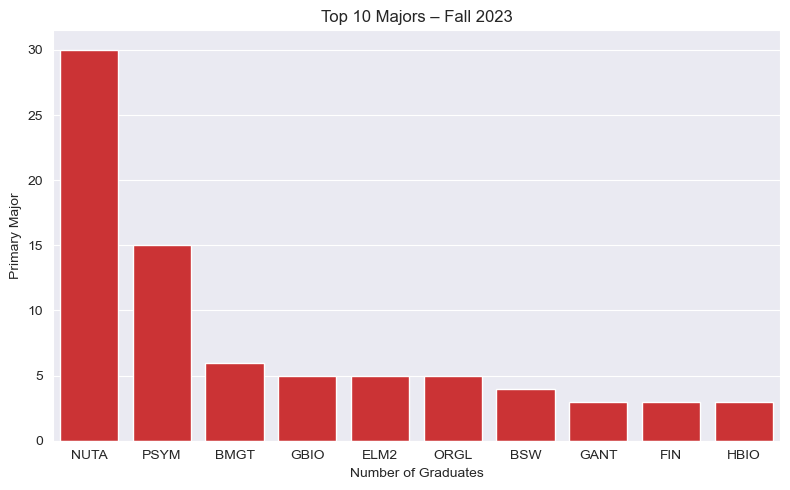

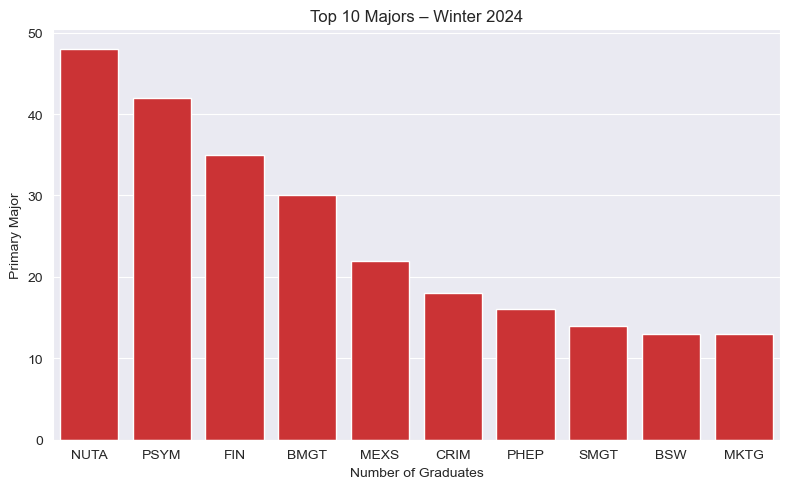

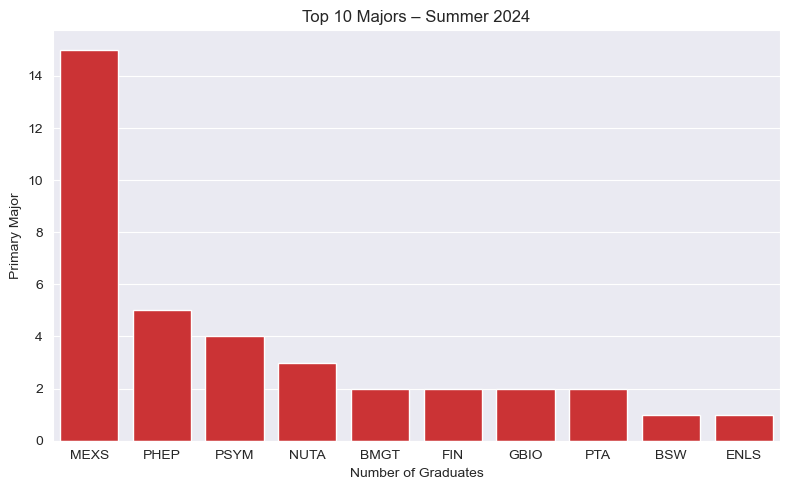

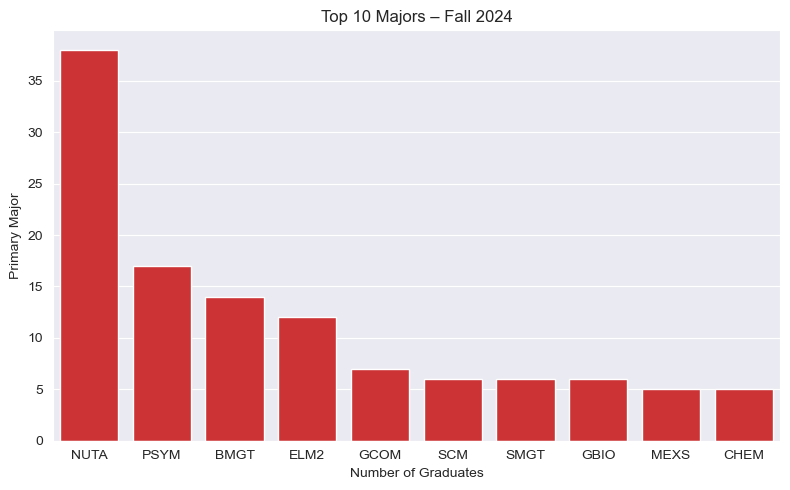

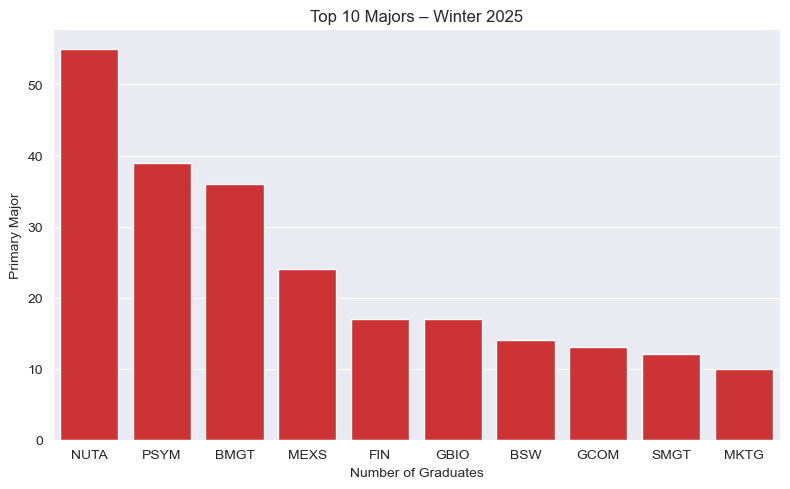

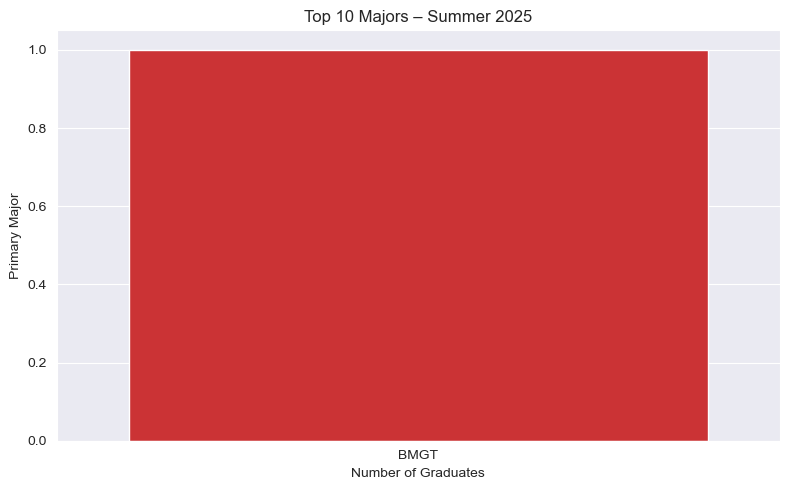

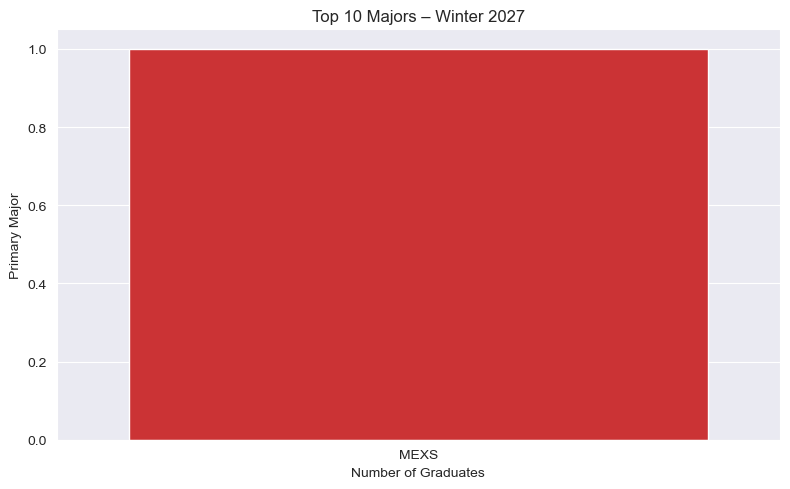

In [20]:
# --- Step 1: Drop missing values ---
plot_df = clean.dropna(subset=["Recipient Primary Major", "Recipient Graduation Date"]).copy()

# --- Step 2: Count number of graduates by (term, major) ---
counts = (
    plot_df.groupby(["Recipient Graduation Date", "Recipient Primary Major"])
    .size()
    .reset_index(name="Count")
)

# --- Step 3: Sort and group ---
# Sort by term (Winter < Summer < Fall within each year)
season_order = {"Winter": 1, "Summer": 2, "Fall": 3}

def term_sort_key(term):
    season, year = term.split()
    return (int(year), season_order[season])

counts = counts.sort_values(by="Recipient Graduation Date", key=lambda x: x.map(term_sort_key))

# --- Step 4: Plot top 10 majors for each term ---
terms = counts["Recipient Graduation Date"].unique()

for term in terms:
    subset = counts[counts["Recipient Graduation Date"] == term].nlargest(10, "Count")

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=subset,
        x="Recipient Primary Major",
        y="Count"
    )

    plt.title(f"Top 10 Majors – {term}")
    plt.xlabel("Number of Graduates")
    plt.ylabel("Primary Major")
    plt.tight_layout()
    plt.show()

In [21]:
sec_majors_count = {}
for sec_major in clean["Recipient Secondary Majors"]:
    if pd.isna(sec_major):
        continue
    if "," in sec_major:
        tmp = sec_major.split(",")
        for i in tmp:
            i = i.strip()
            if i in sec_majors_count:
                sec_majors_count[i] += 1
            else:
                sec_majors_count[i] = 1
    else:
        if sec_major in sec_majors_count:
            sec_majors_count[sec_major] += 1
        else:
            sec_majors_count[sec_major] = 1

print(sec_majors_count)

{'BIOL': 14, 'SOC': 1, 'MKTG': 6, 'FIN': 4, 'SCED': 20, 'SED2': 15, 'SPAN': 9, 'CRIM': 8, 'PRE PHYSICAL THERAPY': 5, 'COMM': 8, 'HIST': 4, 'PSYM': 7, 'PRE OCCUPATIONAL THERAPY': 3, 'EDUC': 2, 'ENSC': 2, 'MATH': 3, 'SOCA': 5, 'APPLIED SOCIOLOGY': 4, 'SOCIOLOGY': 5, 'BADM': 6, 'PMED': 1, 'IREL': 3, 'GART': 3, 'LIBA': 1, 'PSYC': 14, 'ELM2': 2, 'NUB1': 8, 'SPANISH TEACHING': 2, 'SPANISH': 2, 'ENPW': 2, 'FAMILY NP IN PRIMARY CARE': 1, 'ADULT GERO NP/PRIMARY CARE': 1, 'BUSINESS ADMIN & MGMT': 7, 'CHEM': 4, 'NU81': 1, 'SMGT': 5, 'DATA': 2, 'PRE PHARMACY': 1, 'ENCW': 3, 'DOT': 2, 'ART': 1, 'PRE-ART THERAPY': 1, 'ENTR': 1, 'PTA': 2, 'MUS': 2, 'BACCALAUREATE': 1, 'BMGT': 2, 'CRIMINAL JUSTICE': 1, 'IRMA': 2, 'ACC.': 1, 'THE': 2, 'MEXS': 2, 'CSCI': 2, 'PSCI': 4, 'ATRG': 1, 'NUPR': 1, 'MUPR': 2, 'PHYS ED/SPORTS MEDICINE': 1, 'ASOC': 1, 'GRAPHICS DESIGN/VCD': 2, 'ACCT': 2, 'SCM': 5, 'EENG': 1, 'GENS': 1, 'BSW': 1, 'HBIO': 2, 'SART': 3, 'MS': 2, 'SUST': 1, 'ACHM': 1, 'PHEP': 1, 'PRE THEOLOGY': 1, 'EA

In [22]:
from collections import Counter
top_5_sec_majors = Counter(sec_majors_count).most_common(5)
print(top_5_sec_majors)

[('SCED', 20), ('SED2', 15), ('BIOL', 14), ('PSYC', 14), ('SPAN', 9)]


Text(0.5, 1.0, 'Recipient Secondary Major')

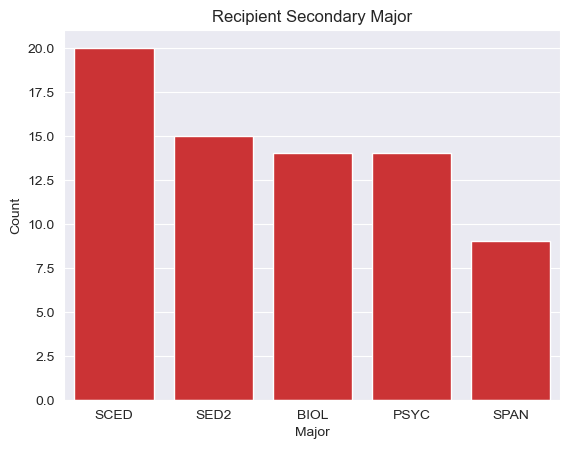

In [23]:
df = pd.DataFrame(top_5_sec_majors, columns=["Major", "Count"])
ax = sns.barplot(df, x="Major", y="Count")
ax.set_title("Recipient Secondary Major")

## Primary College

In [24]:
clean["Recipient Primary College"].unique()

array(['BN', 'AS', 'CH', 'NU', 'BH', 'EB', nan,
       'COLLEGE OF APP. BEHAVIORAL SCI', 'ED'], dtype=object)

<Axes: xlabel='Recipient Primary College', ylabel='count'>

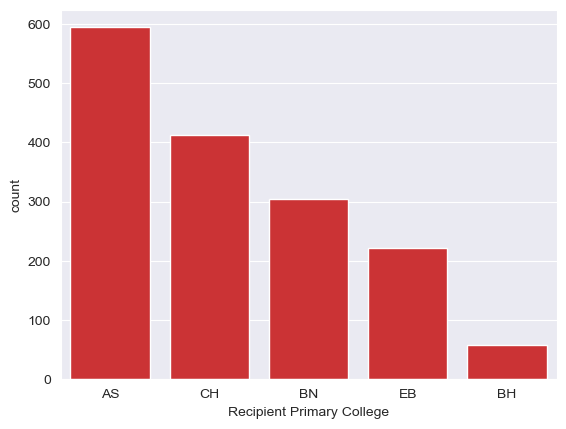

In [25]:
top_5_schools = clean["Recipient Primary College"].value_counts().nlargest(5)
sns.barplot(top_5_schools)

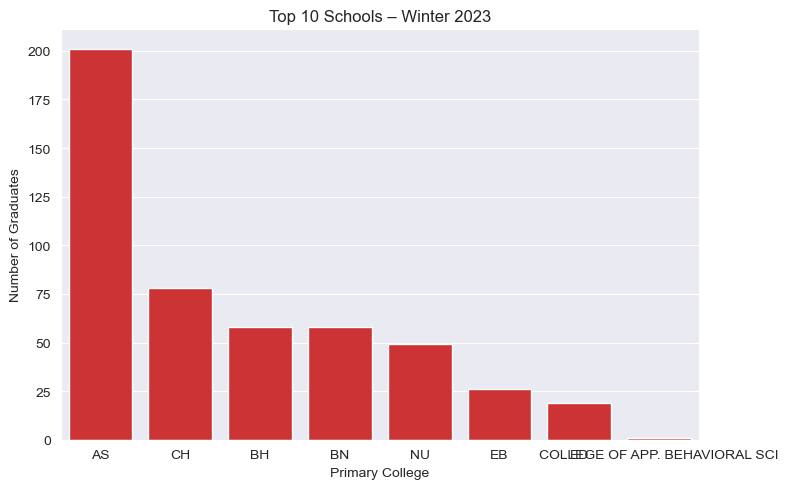

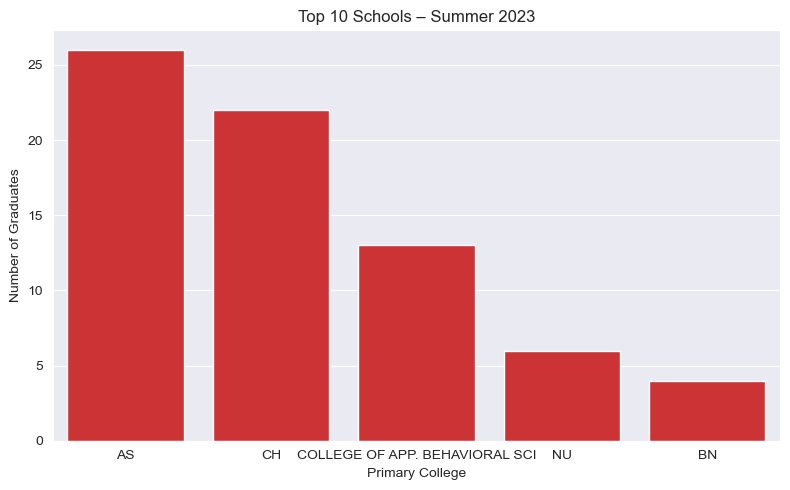

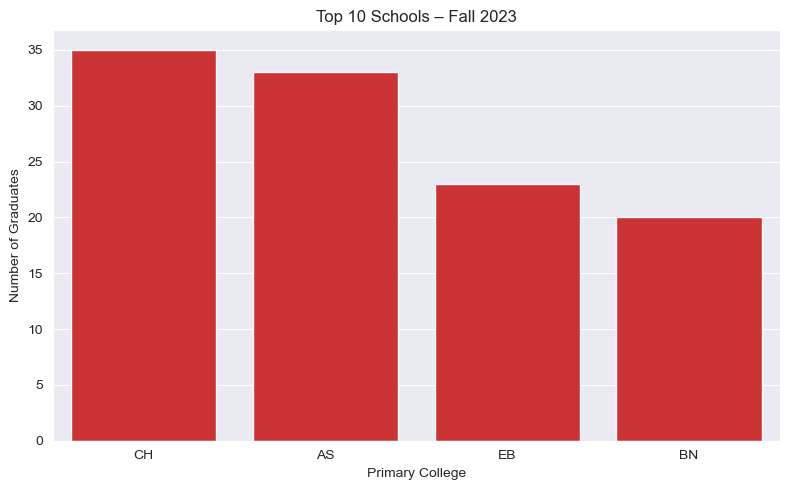

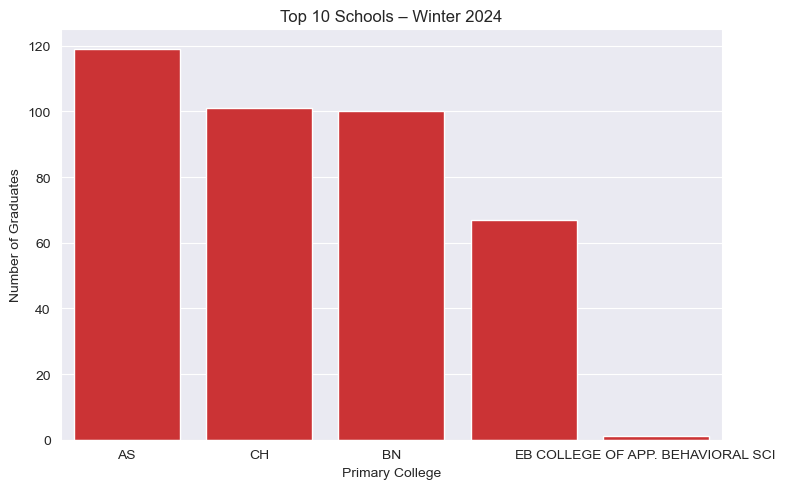

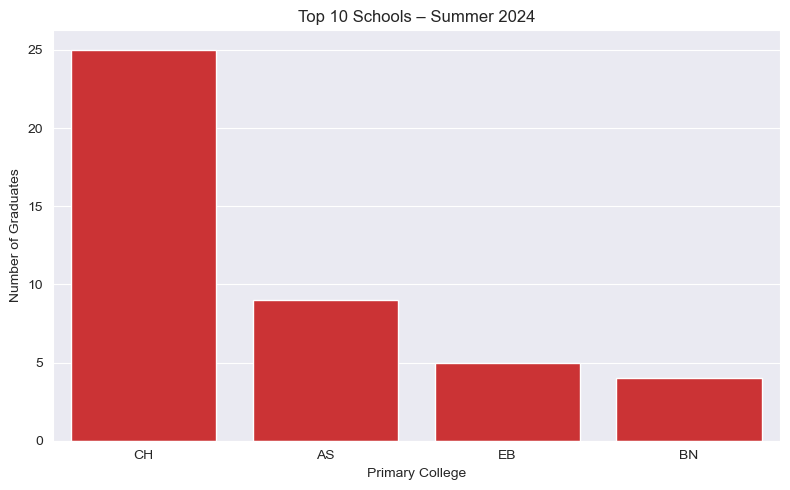

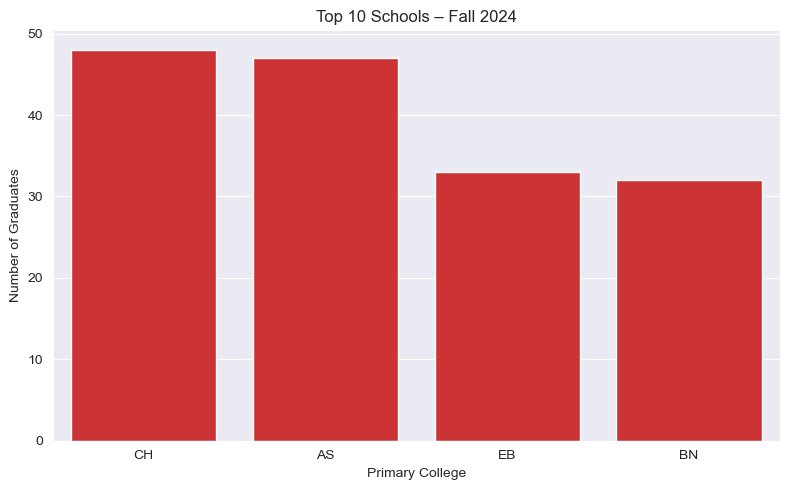

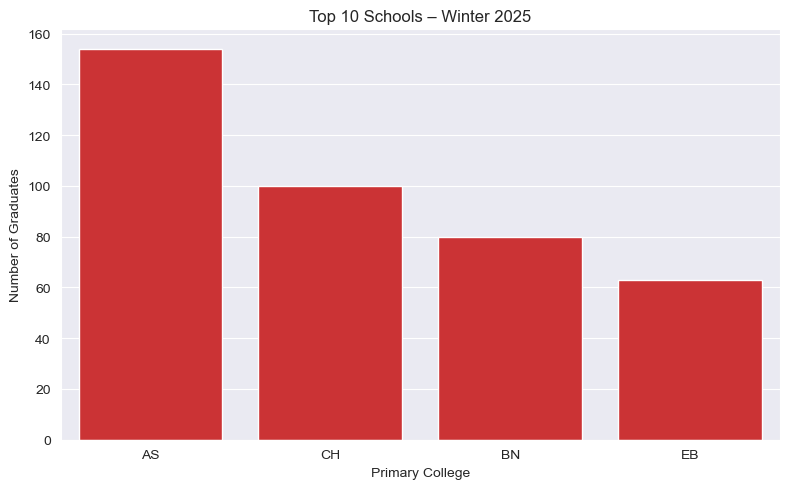

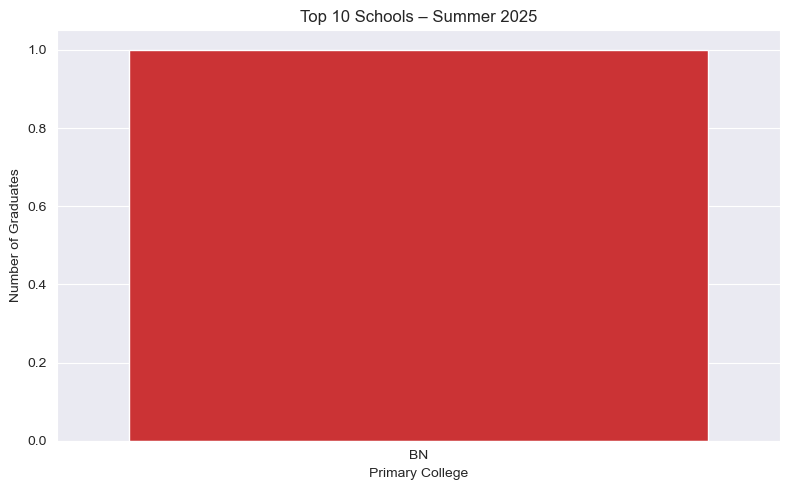

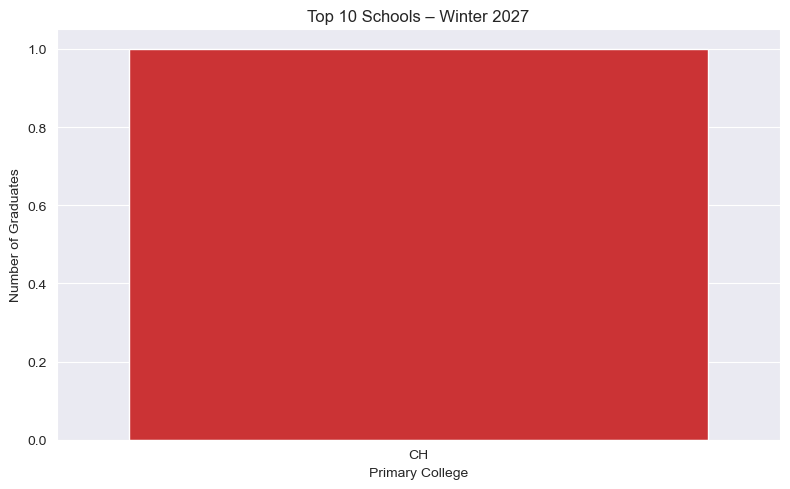

In [26]:
# --- Step 1: Drop missing values ---
plot_df = clean.dropna(subset=["Recipient Primary College", "Recipient Graduation Date"]).copy()

# --- Step 2: Count number of graduates by (term, major) ---
counts = (
    plot_df.groupby(["Recipient Graduation Date", "Recipient Primary College"])
    .size()
    .reset_index(name="Count")
)

# --- Step 3: Sort and group ---
# Sort by term (Winter < Summer < Fall within each year)
season_order = {"Winter": 1, "Summer": 2, "Fall": 3}

def term_sort_key(term):
    season, year = term.split()
    return (int(year), season_order[season])

counts = counts.sort_values(by="Recipient Graduation Date", key=lambda x: x.map(term_sort_key))

# --- Step 4: Plot top 10 majors for each term ---
terms = counts["Recipient Graduation Date"].unique()

for term in terms:
    subset = counts[counts["Recipient Graduation Date"] == term].nlargest(10, "Count")

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=subset,
        x="Recipient Primary College",
        y="Count"
    )

    plt.title(f"Top 10 Schools – {term}")
    plt.xlabel("Primary College")
    plt.ylabel("Number of Graduates")
    plt.tight_layout()
    plt.show()

## Outcome

In [27]:
clean["Outcome"].unique()

array(['Seeking employment',
       'Employed full time (on average 30 hours or more per week)',
       'Pursuing or furthering education (Graduate/Professional)',
       'Planning to further education but not yet enrolled',
       'Participating in a volunteer or service program (e.g., Peace Corps)',
       'Still Looking', 'Working', 'Continuing Education', 'Not Seeking',
       'Employed part time (on average less than 30 hours per week)',
       'Military', 'Volunteering', 'Serving in the U.S. military'],
      dtype=object)

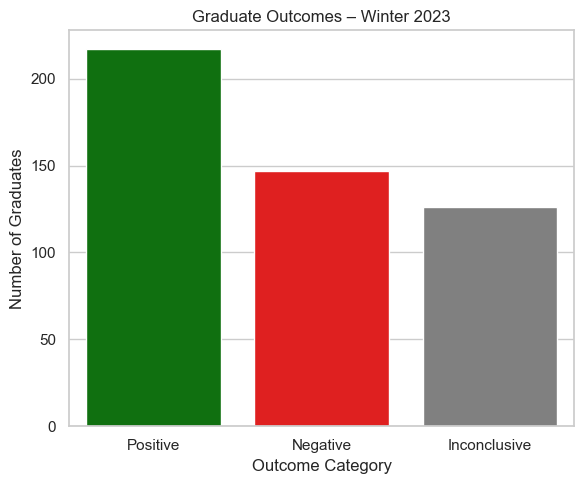

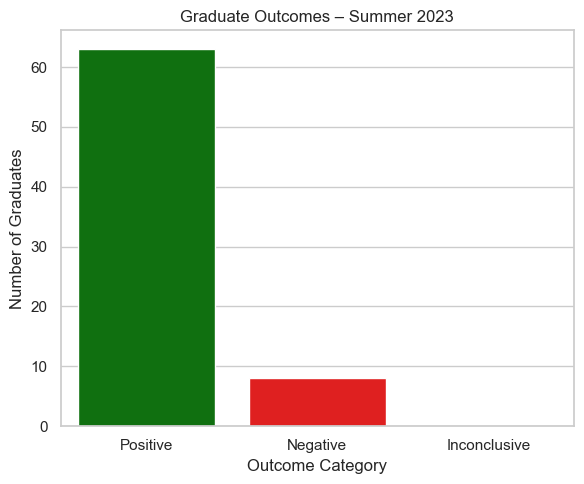

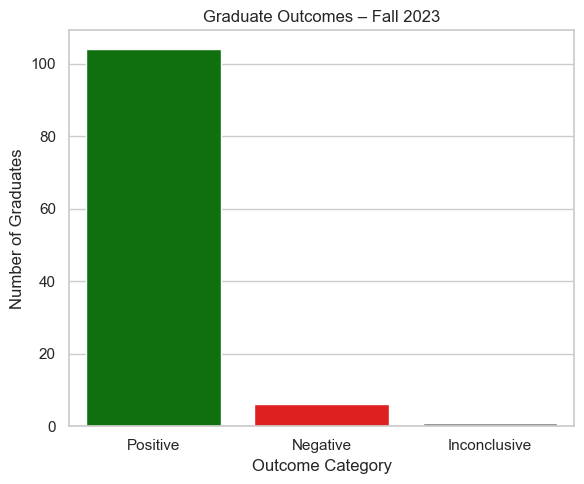

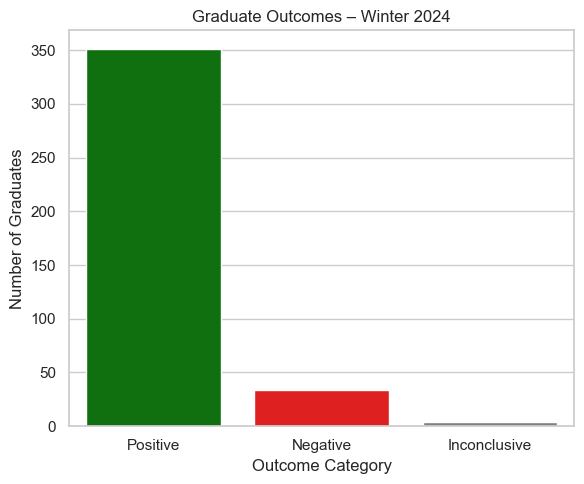

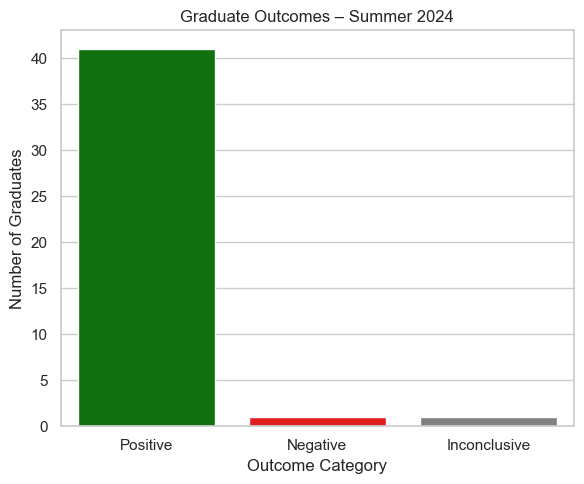

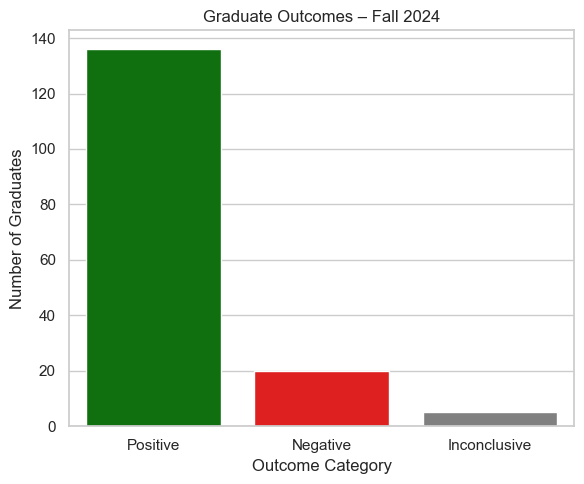

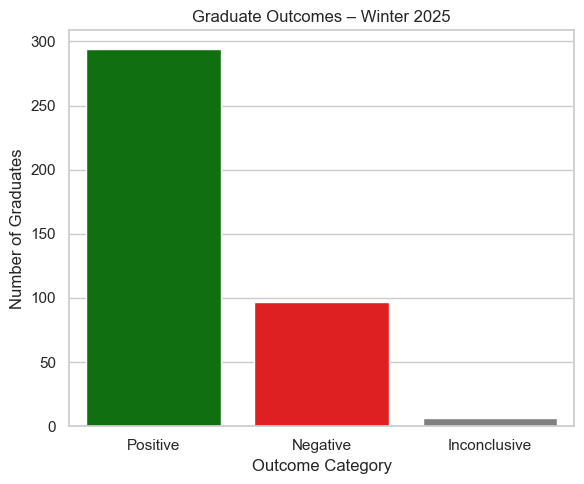

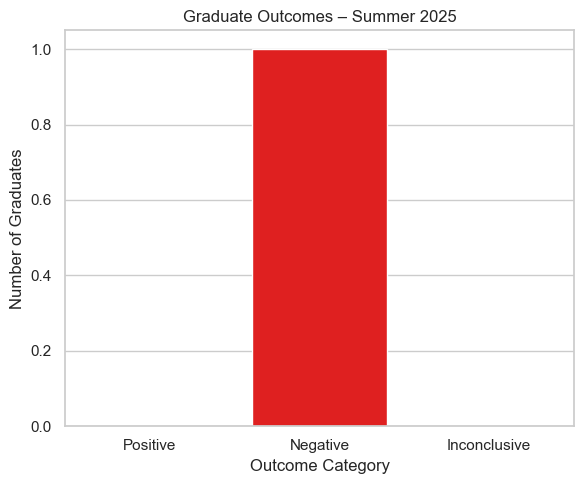

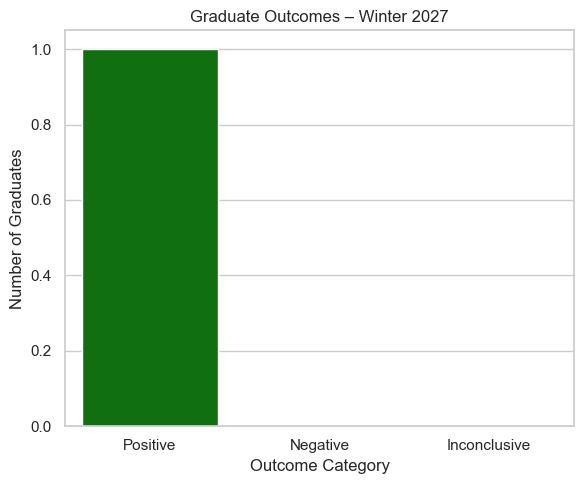

In [28]:
# --- Step 1: Categorize outcomes ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
plot_df = clean.dropna(subset=["Recipient Graduation Date", "Outcome"]).copy()
plot_df["Outcome Category"] = plot_df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count graduates by term and outcome ---
outcome_counts = (
    plot_df.groupby(["Recipient Graduation Date", "Outcome Category"])
    .size()
    .reset_index(name="Count")
)

# --- Step 4: Ensure all outcomes appear for each term (fill missing with 0) ---
all_terms = plot_df["Recipient Graduation Date"].dropna().unique()
outcome_categories = ["Positive", "Negative", "Inconclusive"]

full_index = pd.MultiIndex.from_product(
    [all_terms, outcome_categories],
    names=["Recipient Graduation Date", "Outcome Category"]
)
outcome_counts = (
    outcome_counts.set_index(["Recipient Graduation Date", "Outcome Category"])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

# --- Step 5: Sort terms chronologically ---
season_order = {"Winter": 1, "Summer": 2, "Fall": 3}

def term_sort_key(term):
    season, year = term.split()
    return (int(year), season_order[season])

outcome_counts = outcome_counts.sort_values(
    by="Recipient Graduation Date",
    key=lambda x: x.map(term_sort_key)
)

# --- Step 6: Plot each term (no shared y-axis, consistent colors & order) ---
sns.set(style="whitegrid")
palette = {"Positive": "green", "Negative": "red", "Inconclusive": "gray"}
terms = outcome_counts["Recipient Graduation Date"].unique()
    
for term in terms:
    subset = outcome_counts[outcome_counts["Recipient Graduation Date"] == term]

    plt.figure(figsize=(6, 5))
    sns.barplot(
        data=subset,
        x="Outcome Category",
        y="Count",
        hue="Outcome Category",
        palette=palette,
        order=outcome_categories,
        legend=False
    )

    plt.title(f"Graduate Outcomes – {term}")
    plt.xlabel("Outcome Category")
    plt.ylabel("Number of Graduates")
    plt.tight_layout()
    plt.show()


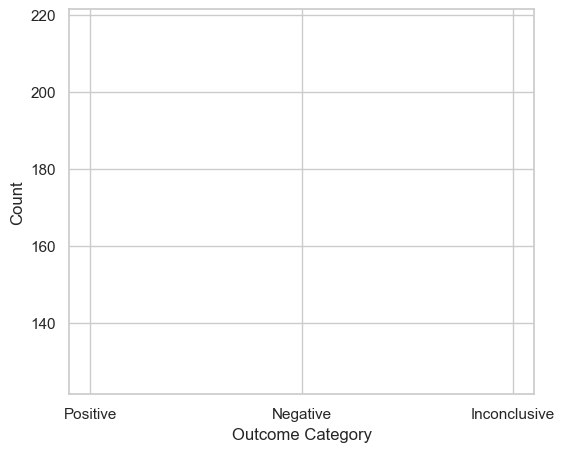

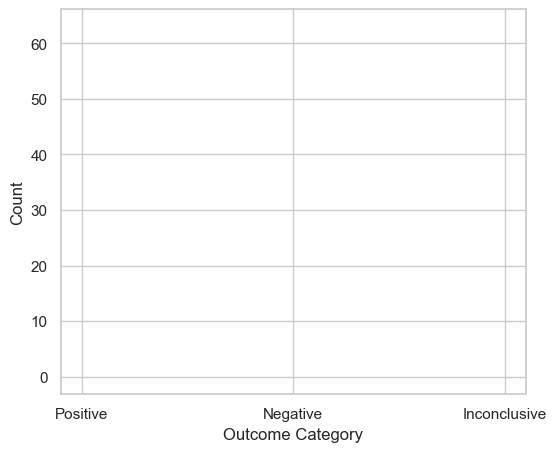

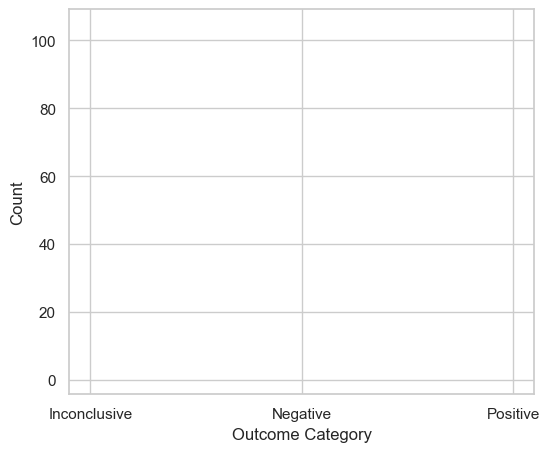

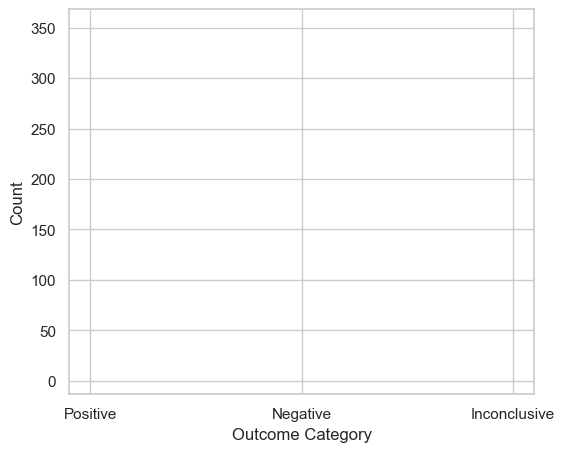

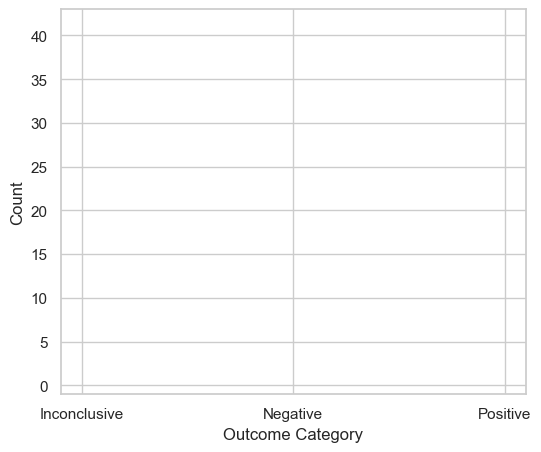

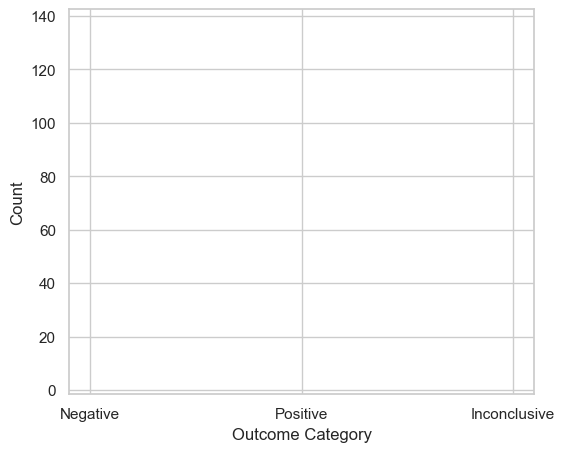

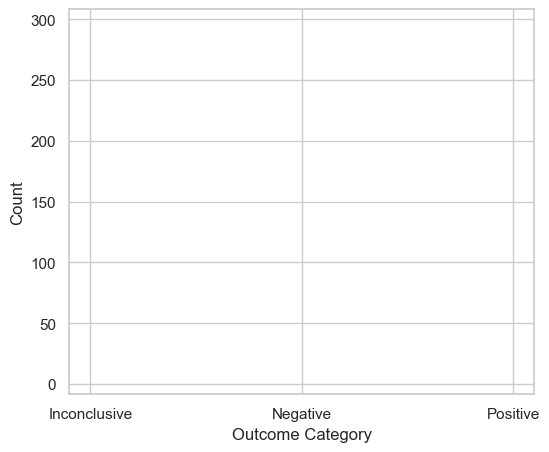

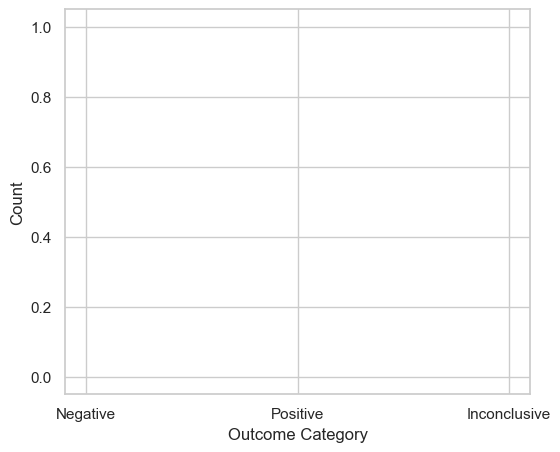

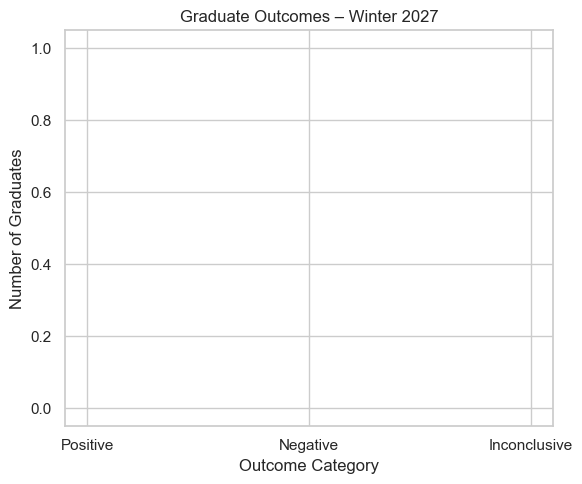

In [29]:
# --- Step 1: Categorize outcomes ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
plot_df = clean.dropna(subset=["Recipient Graduation Date", "Outcome"]).copy()
plot_df["Outcome Category"] = plot_df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count graduates by term and outcome ---
outcome_counts = (
    plot_df.groupby(["Recipient Graduation Date", "Outcome Category"])
    .size()
    .reset_index(name="Count")
)

# --- Step 4: Ensure all outcomes appear for each term (fill missing with 0) ---
all_terms = plot_df["Recipient Graduation Date"].dropna().unique()
outcome_categories = ["Positive", "Negative", "Inconclusive"]

full_index = pd.MultiIndex.from_product(
    [all_terms, outcome_categories],
    names=["Recipient Graduation Date", "Outcome Category"]
)
outcome_counts = (
    outcome_counts.set_index(["Recipient Graduation Date", "Outcome Category"])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

# --- Step 5: Sort terms chronologically ---
season_order = {"Winter": 1, "Summer": 2, "Fall": 3}

def term_sort_key(term):
    season, year = term.split()
    return (int(year), season_order[season])

outcome_counts = outcome_counts.sort_values(
    by="Recipient Graduation Date",
    key=lambda x: x.map(term_sort_key)
)

# --- Step 6: Plot each term (no shared y-axis, consistent colors & order) ---
sns.set(style="whitegrid")
palette = {"Positive": "green", "Negative": "red", "Inconclusive": "gray"}
terms = outcome_counts["Recipient Graduation Date"].unique()

for term in terms:
    subset = outcome_counts[outcome_counts["Recipient Graduation Date"] == term]

    plt.figure(figsize=(6, 5))
    sns.lineplot(
        data=subset,
        x="Outcome Category",
        y="Count",
        hue="Outcome Category",
        palette=palette,
        legend=False
    )

plt.title(f"Graduate Outcomes – {term}")
plt.xlabel("Outcome Category")
plt.ylabel("Number of Graduates")
plt.tight_layout()
plt.show()


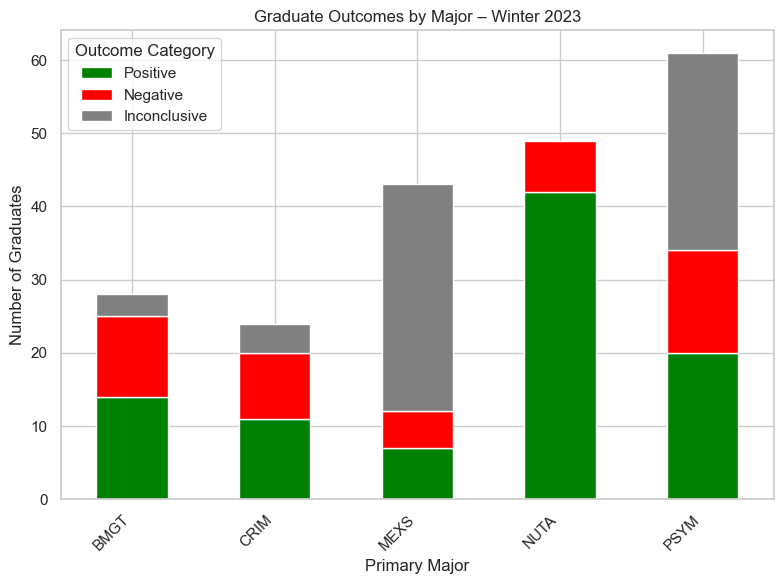

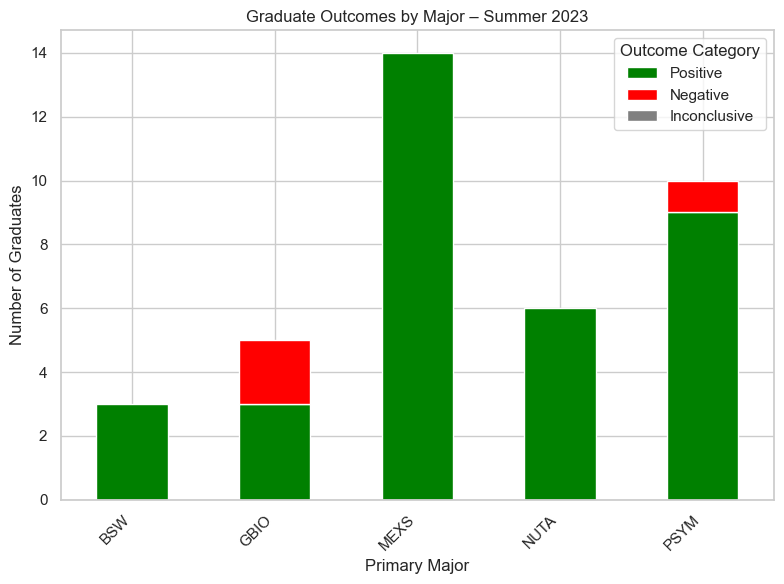

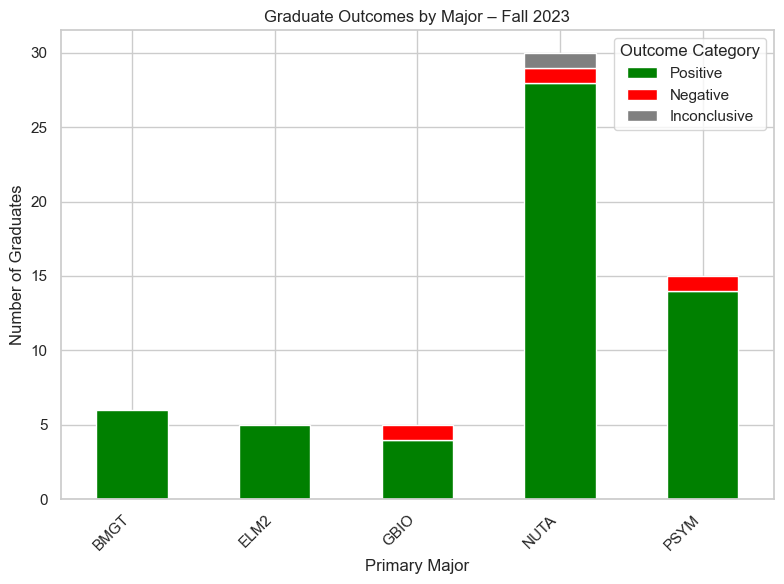

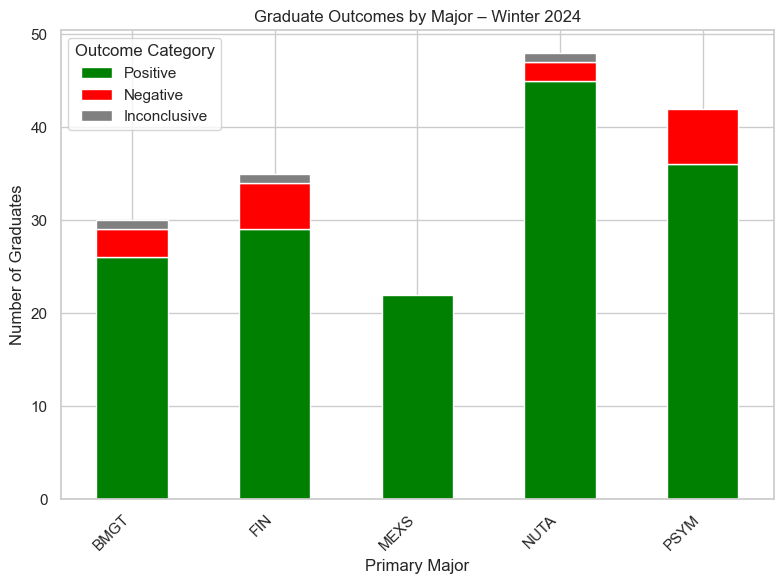

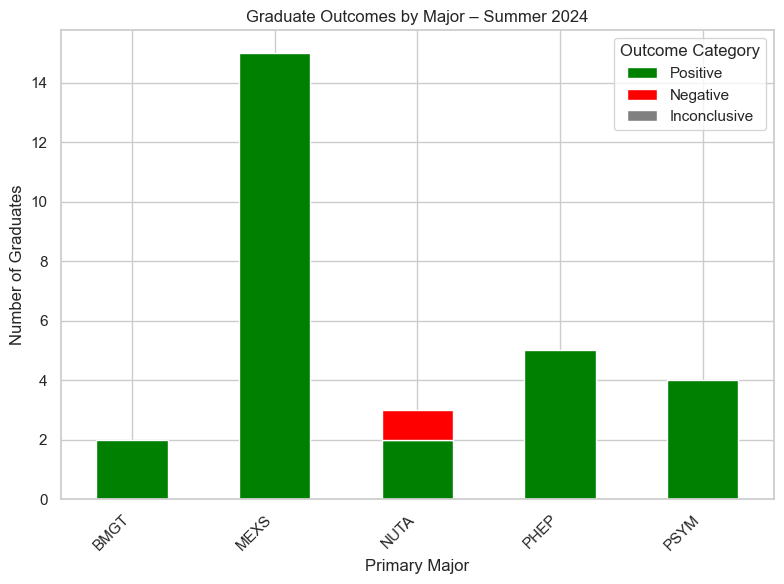

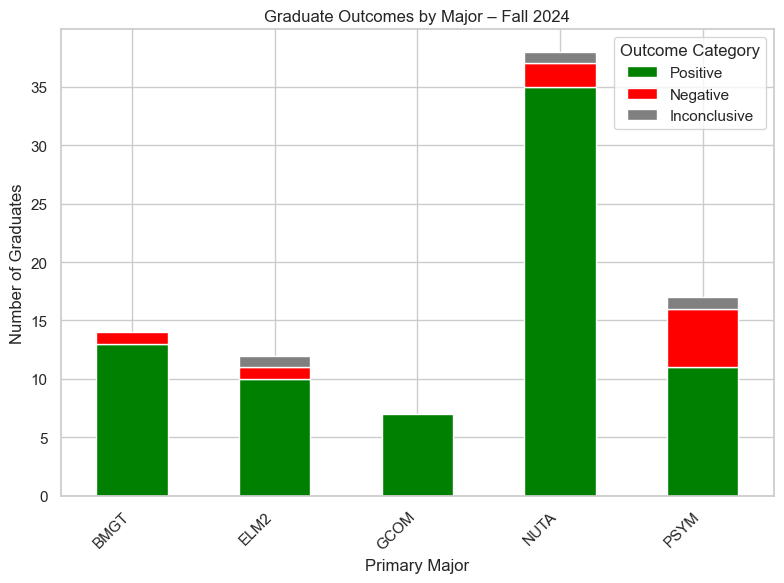

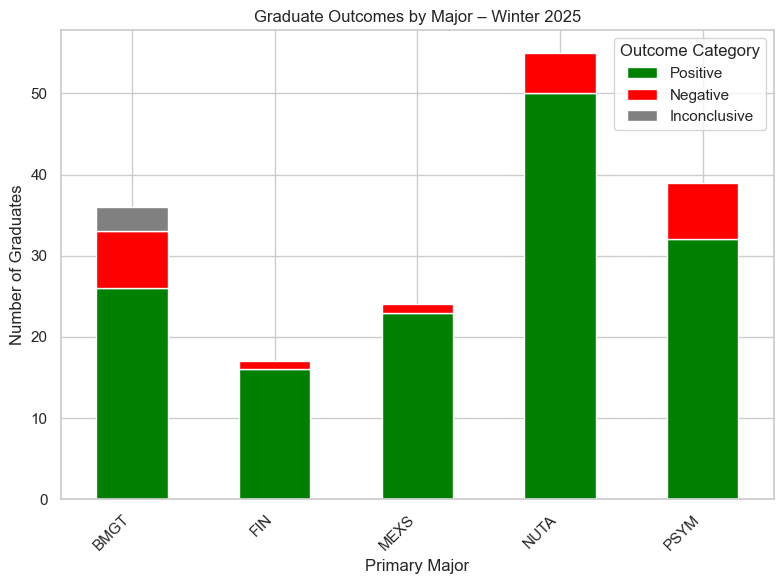

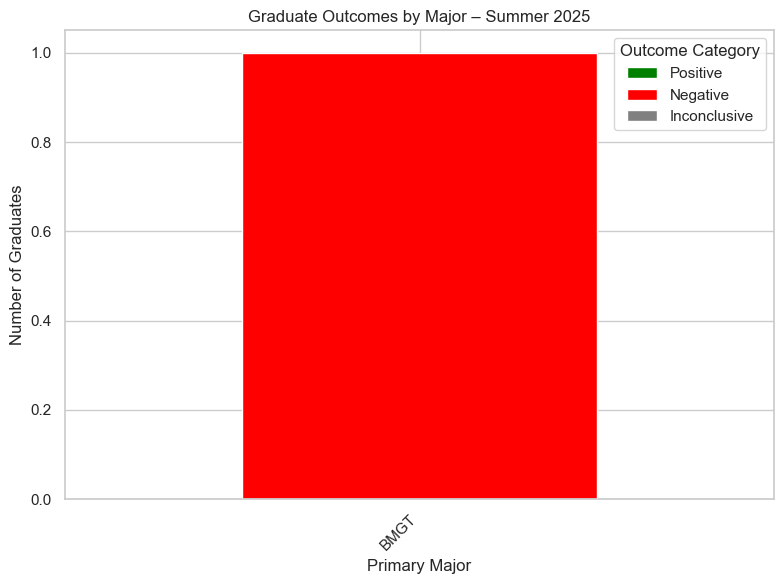

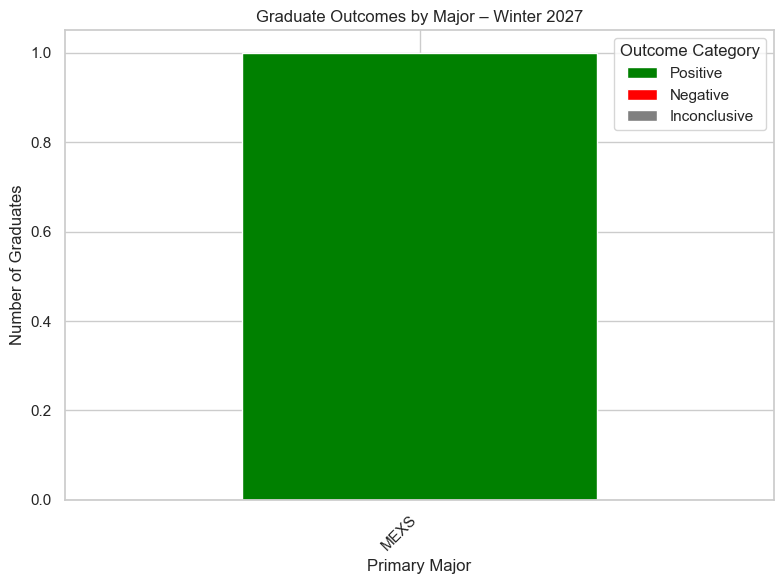

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Categorize outcomes ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
plot_df = clean.dropna(subset=["Recipient Graduation Date", "Outcome", "Recipient Primary Major"]).copy()
plot_df["Outcome Category"] = plot_df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count graduates by term, major, and outcome ---
counts = (
    plot_df.groupby(["Recipient Graduation Date", "Recipient Primary Major", "Outcome Category"])
    .size()
    .reset_index(name="Count")
)

# --- Step 4: Sort terms chronologically ---
season_order = {"Winter": 1, "Summer": 2, "Fall": 3}

def term_sort_key(term):
    season, year = term.split()
    return (int(year), season_order[season])

counts = counts.sort_values(by="Recipient Graduation Date", key=lambda x: x.map(term_sort_key))

# --- Step 5: Define consistent outcome categories and colors ---
outcome_categories = ["Positive", "Negative", "Inconclusive"]
palette = {"Positive": "green", "Negative": "red", "Inconclusive": "gray"}

# --- Step 6: Plot top 5 majors for each term ---
sns.set(style="whitegrid")
terms = counts["Recipient Graduation Date"].unique()

for term in terms:
    subset = counts[counts["Recipient Graduation Date"] == term]
    
    # Select top 5 majors by total graduates for that term
    top_majors = (
        subset.groupby("Recipient Primary Major")["Count"].sum()
        .nlargest(5)
        .index
    )
    subset = subset[subset["Recipient Primary Major"].isin(top_majors)]
    
    # Pivot for stacked bars
    pivot_df = subset.pivot_table(
        index="Recipient Primary Major",
        columns="Outcome Category",
        values="Count",
        fill_value=0
    )

    # Ensure all three categories exist even if missing
    for outcome in outcome_categories:
        if outcome not in pivot_df.columns:
            pivot_df[outcome] = 0

    # Reorder columns
    pivot_df = pivot_df[outcome_categories]

    # Plot stacked vertical bars
    pivot_df.plot(
        kind="bar",
        stacked=True,
        color=[palette[o] for o in outcome_categories],
        figsize=(8, 6)
    )

    plt.title(f"Graduate Outcomes by Major – {term}")
    plt.xlabel("Primary Major")
    plt.ylabel("Number of Graduates")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Outcome Category")
    plt.tight_layout()
    plt.show()

In [33]:
len(clean["Recipient Primary Major"].unique())

67

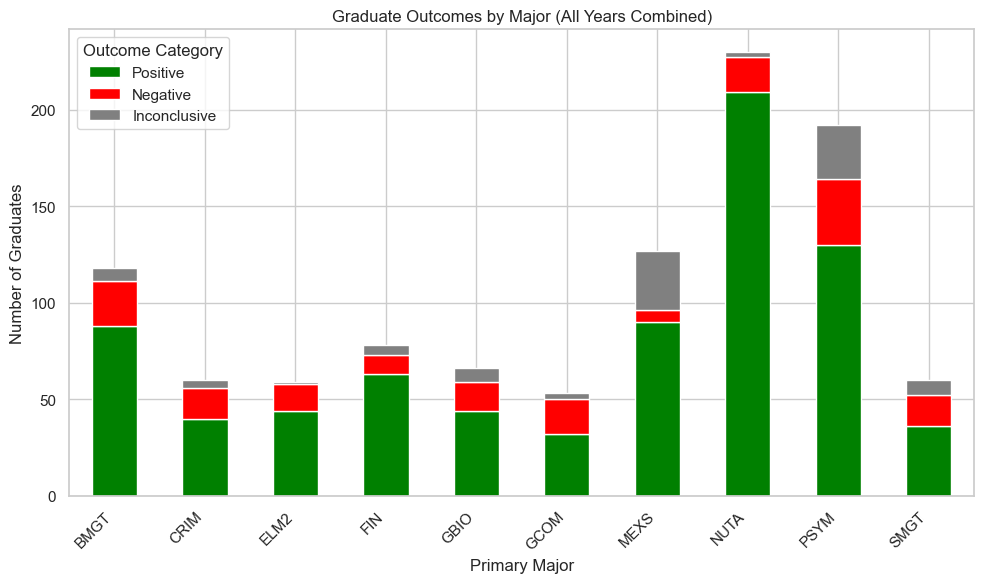

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Categorize outcomes ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
plot_df = clean.dropna(subset=["Outcome", "Recipient Primary Major"]).copy()
plot_df["Outcome Category"] = plot_df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count graduates by major and outcome ---
counts = (
    plot_df.groupby(["Recipient Primary Major", "Outcome Category"])
    .size()
    .reset_index(name="Count")
)

# --- Step 4: Select top 10 majors overall ---
top_majors = (
    counts.groupby("Recipient Primary Major")["Count"]
    .sum()
    .nlargest(10)
    .index
)
counts = counts[counts["Recipient Primary Major"].isin(top_majors)]

# --- Step 5: Ensure consistent outcome categories ---
outcome_categories = ["Positive", "Negative", "Inconclusive"]
palette = {"Positive": "green", "Negative": "red", "Inconclusive": "gray"}

# --- Step 6: Pivot for stacked bar chart ---
pivot_df = counts.pivot_table(
    index="Recipient Primary Major",
    columns="Outcome Category",
    values="Count",
    fill_value=0
)

# Ensure all outcome columns exist
for o in outcome_categories:
    if o not in pivot_df.columns:
        pivot_df[o] = 0

pivot_df = pivot_df[outcome_categories]

# --- Step 7: Plot ---
sns.set(style="whitegrid")

pivot_df.plot(
    kind="bar",
    stacked=True,
    color=[palette[o] for o in outcome_categories],
    figsize=(10, 6)
)

plt.title("Graduate Outcomes by Major (All Years Combined)")
plt.xlabel("Primary Major")
plt.ylabel("Number of Graduates")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Outcome Category")
plt.tight_layout()
plt.show()


In [35]:
# --- Step 1: Categorize outcomes ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
plot_df = clean.dropna(subset=["Outcome", "Recipient Primary Major"]).copy()
plot_df["Outcome Category"] = plot_df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count outcomes by major ---
outcome_counts = (
    plot_df.groupby(["Recipient Primary Major", "Outcome Category"])
    .size()
    .unstack(fill_value=0)
)

# Ensure all expected columns exist
for col in ["Positive", "Negative", "Inconclusive"]:
    if col not in outcome_counts.columns:
        outcome_counts[col] = 0

# --- Step 4: Compute proportions ---
outcome_counts["Total Graduates"] = outcome_counts.sum(axis=1)
outcome_counts["Positive Rate (%)"] = (outcome_counts["Positive"] / outcome_counts["Total Graduates"]) * 100
outcome_counts["Negative Rate (%)"] = (outcome_counts["Negative"] / outcome_counts["Total Graduates"]) * 100
outcome_counts["Inconclusive Rate (%)"] = (outcome_counts["Inconclusive"] / outcome_counts["Total Graduates"]) * 100

# --- Step 5: Sort majors from worst → best by Positive Rate ---
sorted_table = (
    outcome_counts
    .sort_values(by="Positive Rate (%)", ascending=True)
    .reset_index()
    [["Recipient Primary Major", "Total Graduates", "Positive Rate (%)", "Negative Rate (%)", "Inconclusive Rate (%)"]]
)

# --- Step 6: Round values for display ---
sorted_table[["Positive Rate (%)", "Negative Rate (%)", "Inconclusive Rate (%)"]] = (
    sorted_table[["Positive Rate (%)", "Negative Rate (%)", "Inconclusive Rate (%)"]].round(1)
)

# --- Step 7: Display top 10 worst majors ---
print("Top 10 Worst Majors by Positive Outcome Rate (Worst → Best):")
display(sorted_table.head(10))


Top 10 Worst Majors by Positive Outcome Rate (Worst → Best):


Outcome Category,Recipient Primary Major,Total Graduates,Positive Rate (%),Negative Rate (%),Inconclusive Rate (%)
0,MUSJ,2,0.0,100.0,0.0
1,IS,1,0.0,0.0,100.0
2,SLD,3,0.0,33.3,66.7
3,SWEN,4,25.0,75.0,0.0
4,ESCI,9,33.3,55.6,11.1
5,GCSC,18,38.9,61.1,0.0
6,VCD,15,40.0,60.0,0.0
7,K-12,10,40.0,60.0,0.0
8,ENGLISH/PROFESSIONAL WRITING,5,40.0,40.0,20.0
9,HIST,21,42.9,42.9,14.3


In [35]:
len(clean["Recipient Primary Major"].unique())

67

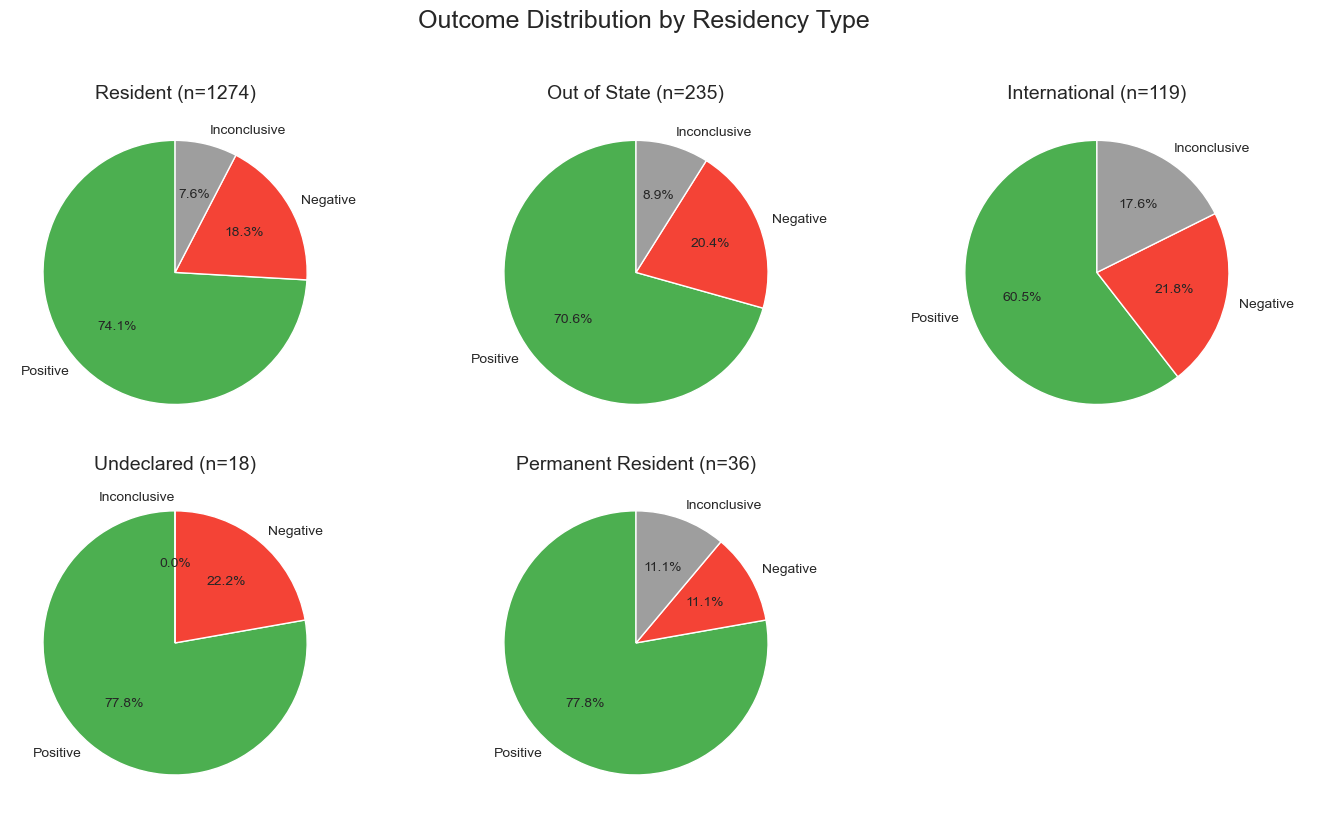

In [36]:
# --- Step 1: Define outcome categories ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare the data ---
df = clean.dropna(subset=["RESIDENCY", "Outcome"]).copy()
df["Outcome Category"] = df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count outcomes per residency ---
counts = (
    df.groupby(["RESIDENCY", "Outcome Category"])
      .size()
      .unstack(fill_value=0)
)

# --- Step 4: Ensure all outcome categories exist ---
for col in ["Positive", "Negative", "Inconclusive"]:
    if col not in counts.columns:
        counts[col] = 0

# --- Step 5: Set up plot layout ---
outcome_colors = {
    "Positive": "#4CAF50",      # green
    "Negative": "#F44336",      # red
    "Inconclusive": "#9E9E9E"   # gray
}

# Define expected residency categories (adjust if needed)
residencies = ["Resident", "Out of State", "International", "Undeclared", "Permanent Resident"]
residencies_present = [r for r in residencies if r in counts.index]
num_residencies = len(residencies_present)

# Create a grid layout (2 rows × 3 columns works up to 6)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.flatten()

# --- Step 6: Plot pies ---
for i, residency in enumerate(residencies_present):
    values = counts.loc[residency, ["Positive", "Negative", "Inconclusive"]]
    total = values.sum()

    axes[i].pie(
        values,
        labels=values.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=[outcome_colors[k] for k in values.index],
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f"{residency} (n={total})", fontsize=14)

# Hide unused subplots if fewer than 6
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Outcome Distribution by Residency Type", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


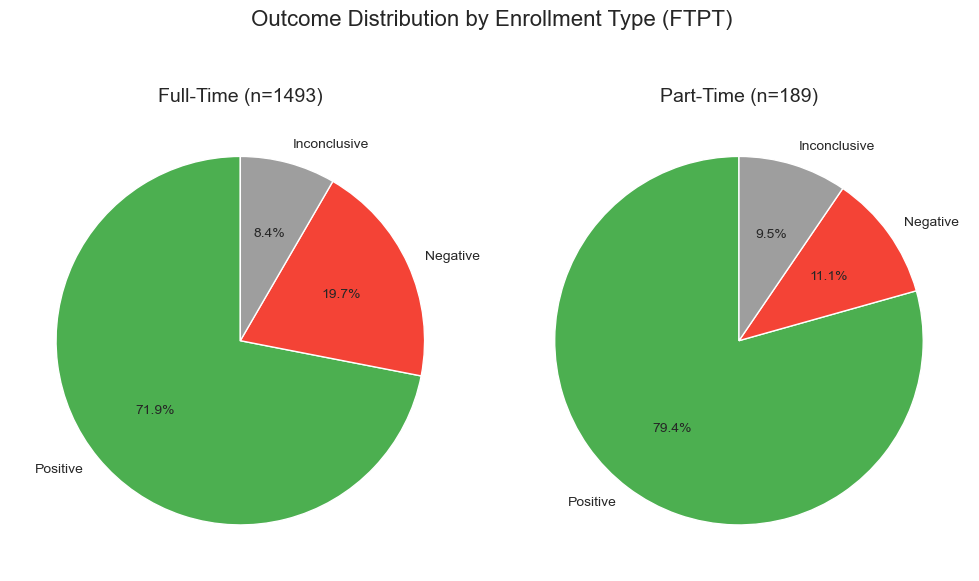

In [37]:
# --- Step 1: Define outcome categories ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare the data ---
df = clean.dropna(subset=["FTPT", "Outcome"]).copy()
df["Outcome Category"] = df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count outcomes per FTPT type ---
counts = (
    df.groupby(["FTPT", "Outcome Category"])
      .size()
      .unstack(fill_value=0)
)

# --- Step 4: Ensure all outcome categories exist ---
for col in ["Positive", "Negative", "Inconclusive"]:
    if col not in counts.columns:
        counts[col] = 0

# --- Step 5: Define colors and setup layout ---
outcome_colors = {
    "Positive": "#4CAF50",      # green
    "Negative": "#F44336",      # red
    "Inconclusive": "#9E9E9E"   # gray
}

ftpt_types = counts.index.tolist()

# --- Step 6: Plot pie charts ---
fig, axes = plt.subplots(1, len(ftpt_types), figsize=(10, 6))

if len(ftpt_types) == 1:
    axes = [axes]  # ensure iterable if only one FTPT category

for ax, ftpt in zip(axes, ftpt_types):
    values = counts.loc[ftpt, ["Positive", "Negative", "Inconclusive"]]
    total = values.sum()

    ax.pie(
        values,
        labels=values.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=[outcome_colors[k] for k in values.index],
        textprops={'fontsize': 10}
    )
    ax.set_title(f"{ftpt} (n={total})", fontsize=14)

plt.suptitle("Outcome Distribution by Enrollment Type (FTPT)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


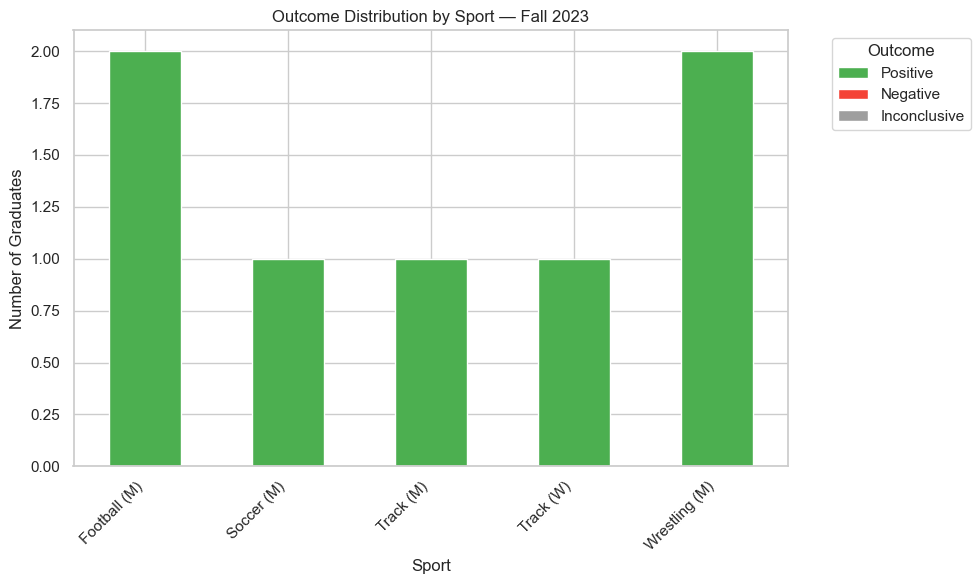

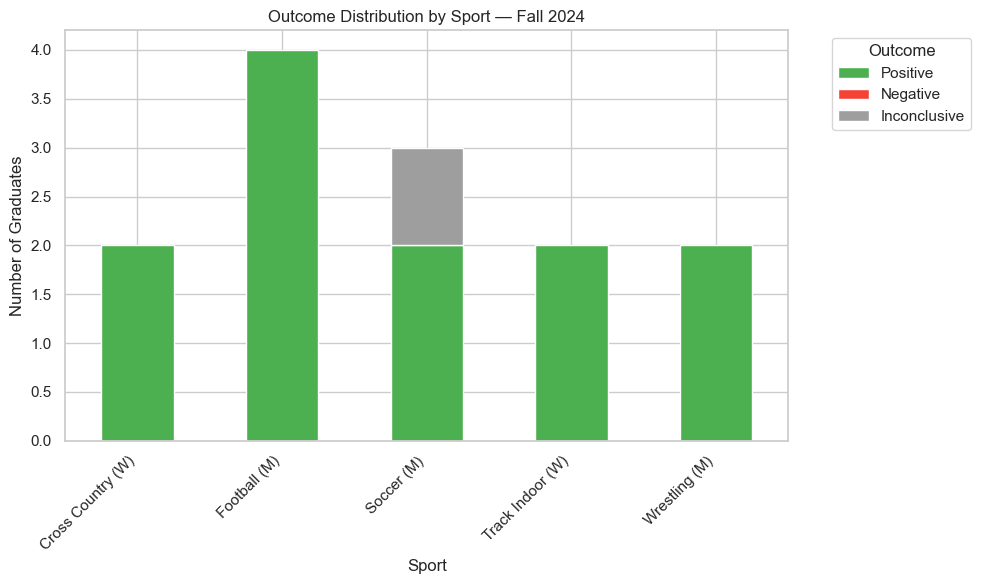

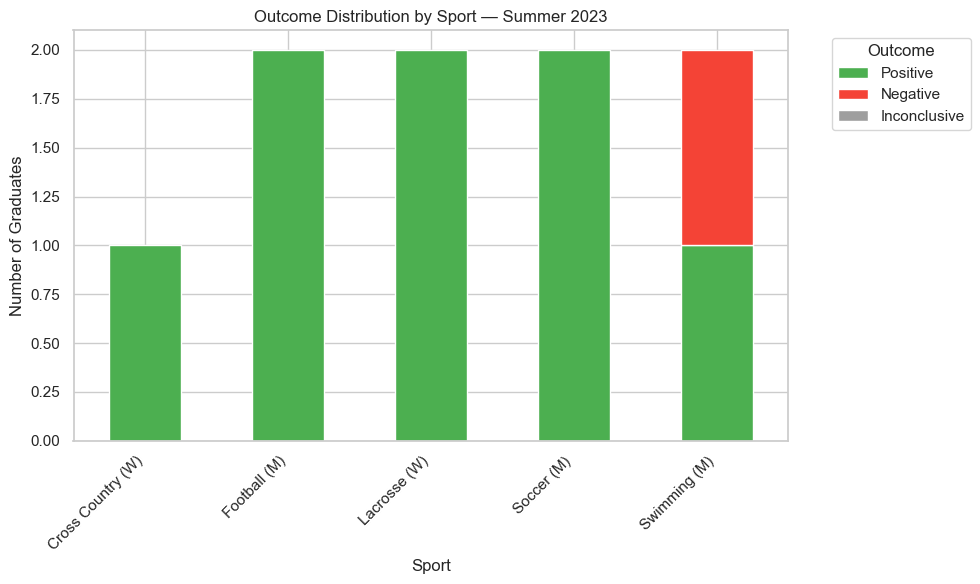

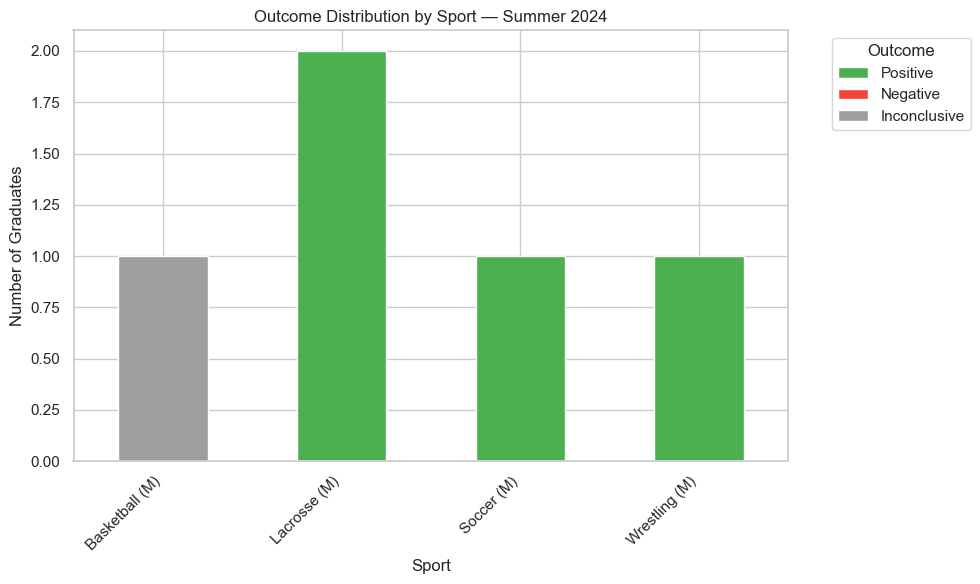

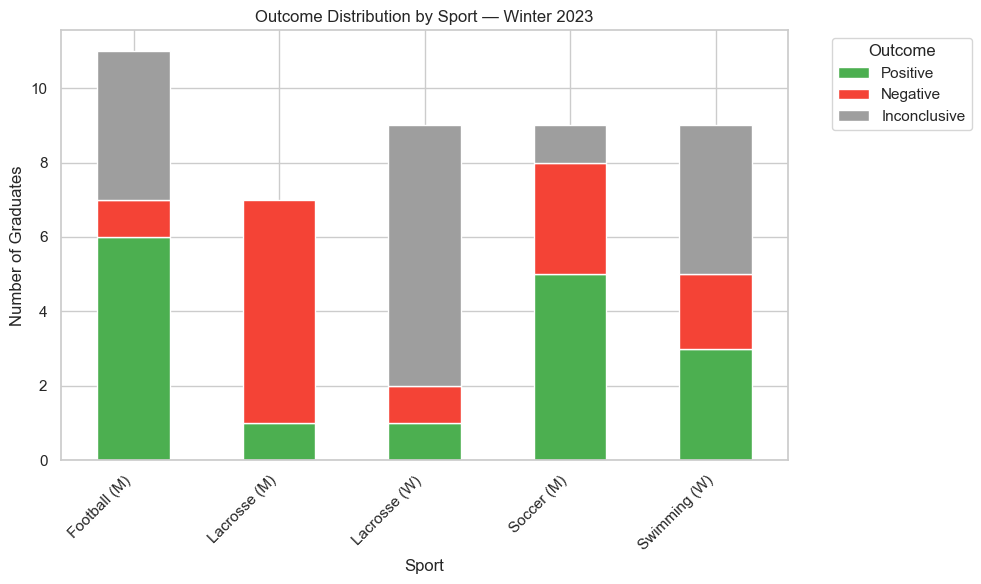

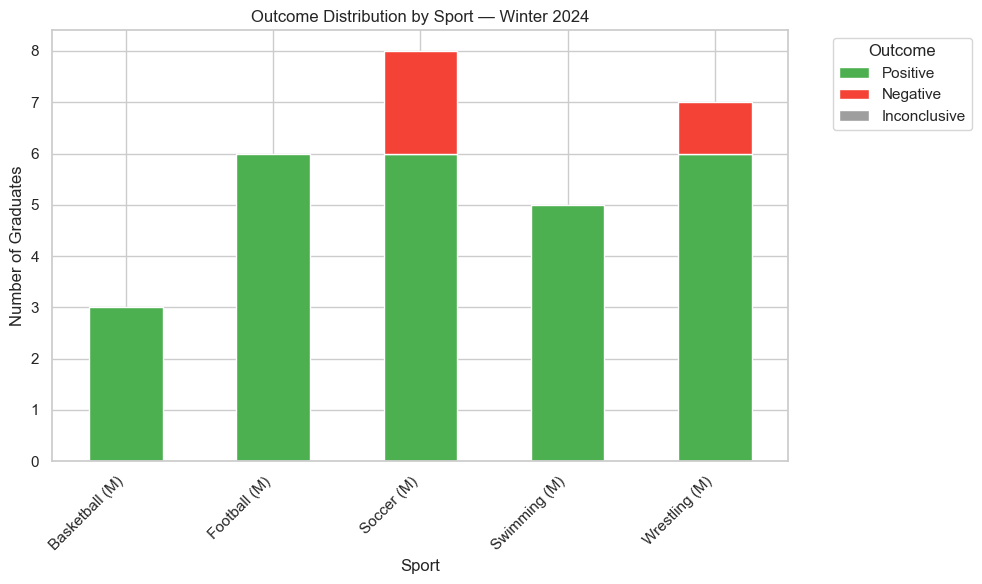

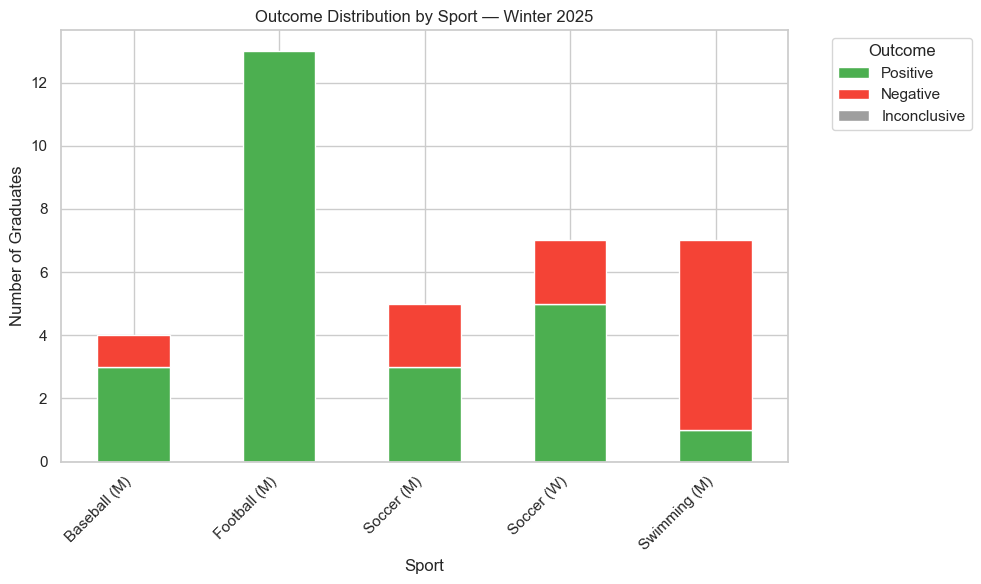

In [38]:
# --- Step 1: Define outcome categories ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
df = clean.dropna(subset=["SPORT_1", "Outcome", "Recipient Graduation Date"]).copy()
df["Outcome Category"] = df["Outcome"].apply(categorize_outcome)

# --- Step 3: Extract season and year ---
def extract_season_year(term):
    if pd.isna(term):
        return None
    parts = str(term).split()
    if len(parts) == 2:
        season, year = parts
        return f"{season.title()} {year}"
    return None

df["SeasonYear"] = df["Recipient Graduation Date"].apply(extract_season_year)

# --- Step 4: Find top 5 sports per season ---
top5_sports_per_season = (
    df.groupby(["SeasonYear", "SPORT_1"])
      .size()
      .reset_index(name="Count")
      .sort_values(["SeasonYear", "Count"], ascending=[True, False])
      .groupby("SeasonYear")
      .head(5)
)

# --- Step 5: Keep only top 5 per season ---
df = df.merge(top5_sports_per_season[["SeasonYear", "SPORT_1"]], on=["SeasonYear", "SPORT_1"])

# --- Step 6: Count outcomes per sport per season ---
counts = (
    df.groupby(["SeasonYear", "SPORT_1", "Outcome Category"])
      .size()
      .reset_index(name="Count")
)

# --- Step 7: Define consistent outcome order ---
outcome_order = ["Positive", "Negative", "Inconclusive"]

# --- Step 8: Plot by season ---
sns.set(style="whitegrid")
seasons = counts["SeasonYear"].unique()

for season in seasons:
    subset = counts[counts["SeasonYear"] == season]
    pivot = subset.pivot(index="SPORT_1", columns="Outcome Category", values="Count").fillna(0)

    # ✅ Ensure all outcomes are present
    for col in outcome_order:
        if col not in pivot.columns:
            pivot[col] = 0

    pivot = pivot[outcome_order]

    pivot.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        color=["#4CAF50", "#F44336", "#9E9E9E"]
    )
    plt.title(f"Outcome Distribution by Sport — {season}")
    plt.xlabel("Sport")
    plt.ylabel("Number of Graduates")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Outcome", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [39]:
import pandas as pd

# --- Step 1: Define outcome categorization ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
df = clean.dropna(subset=["SPORT_1", "Outcome"]).copy()
df["Outcome Category"] = df["Outcome"].apply(categorize_outcome)

# --- Step 3: Count outcomes per sport ---
counts = (
    df.groupby(["SPORT_1", "Outcome Category"])
      .size()
      .unstack(fill_value=0)
)

# Ensure all outcome columns exist
for col in ["Positive", "Negative", "Inconclusive"]:
    if col not in counts.columns:
        counts[col] = 0

# --- Step 4: Calculate total and % Negative ---
counts["Total"] = counts.sum(axis=1)
counts["% Negative"] = (counts["Negative"] / counts["Total"]) * 100

# --- Step 5: Sort by % Negative descending (worst first) ---
worst_sports_df = (
    counts[["Positive", "Negative", "Inconclusive", "Total", "% Negative"]]
    .sort_values(by="% Negative", ascending=False)
    .reset_index()
)

# --- Step 6: Display as DataFrame ---
worst_sports_df.head(10)

Outcome Category,SPORT_1,Positive,Negative,Inconclusive,Total,% Negative
0,Track (M),3,3,0,6,50.000000
1,Tennis (W),1,1,0,2,50.000000
2,Lacrosse (M),8,7,0,15,46.666667
3,Basketball (M),6,4,1,11,36.363636
4,Swimming (M),13,8,2,23,34.782609
5,Soccer (W),9,4,1,14,28.571429
6,Track (W),3,1,0,4,25.000000
7,Tennis (M),0,1,3,4,25.000000
8,Soccer (M),20,7,2,29,24.137931
9,Volleyball (W),4,1,0,5,20.000000


## Employer

In [40]:
from rapidfuzz import fuzz

company_names = clean["Employer Name"].dropna().tolist()
threshold = 90

groups = []
used = set()
for i, name in enumerate(company_names):
        if i in used:
            continue

        group = [name]
        used.add(i)

        for j, other in enumerate(company_names):
            if j in used:
                continue

            # Compare similarity
            similarity = fuzz.ratio(name.lower(), other.lower())
            if similarity >= threshold or name.lower() in other.lower() or other.lower() in name.lower():
                group.append(other)
                used.add(j)

        groups.append(group)
print(groups)
print(len(groups))

[['Roche', 'Roche', 'Roche', 'Roche', 'Roche', 'Roche', 'Roche', 'Roche Diagnostics ', 'Roche Diagnostics ', 'Roche', 'Roche', 'Roche Diagnosics ', 'Roche Diagnostics  ', 'Roche', 'Roche', 'Roche', 'Roche Diagnostics ', 'Roche', 'Roche Diagnostics', 'Roche', 'Roche Diagnostics', 'Roche Diagnostics', 'Roche Diagnostics ', 'Roche', 'Roche', 'Roche'], ['Credence Innovations', 'no', 'Credence Innovations', 'Credence Innovations'], ['IU Health', 'IU Health Bloomington Hospital ', 'IU Health', 'IU Health', 'IU Health ', 'IU Health', 'IU Health', 'IU Health', 'IU Health', 'IU Health Ball Memorial Hospital', 'iu health', 'IU Health', 'IU HEALTH', 'IU Health ', 'IU Health', 'IU Health', 'Iu health', 'IU health', 'IU Health', 'IU Health', 'IU Health North'], ['St Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franciscan Health', 'Franc

In [41]:
mapping = {}
for group in groups:
    # Count frequency of each name in the dataframe
    counts = Counter([name for name in clean["Employer Name"] if name in group])
    # Pick the most frequent
    most_common = counts.most_common(1)[0][0]
    for name in group:
        mapping[name] = most_common

# Replace in dataframe
clean["Employer"] = clean["Employer Name"].map(mapping)
print("Old:", len(clean["Employer Name"].unique()))
print("New:", len(clean["Employer"].unique()))
clean[["Employer Name", "Employer"]].dropna().head(20)

Old: 560
New: 484


,Employer Name,Employer
1,Roche,Roche
3,Credence Innovations,Credence Innovations
8,IU Health,IU Health
13,St Franciscan Health,Franciscan Health
15,Eskenazi Health,Eskenazi Health
19,BANK,The National Bank of Indianapolis
22,Enterprise,Enterprise Mobility
25,State Farm - Michelle Twitchell Insurance Agen...,State Farm - Michelle Twitchell Insurance Agen...
27,Indiana University Health,Indiana University Health
36,"Team Rehab Physical Therapy, P.C.","Team Rehab Physical Therapy, P.C."


<Axes: xlabel='Employer', ylabel='count'>

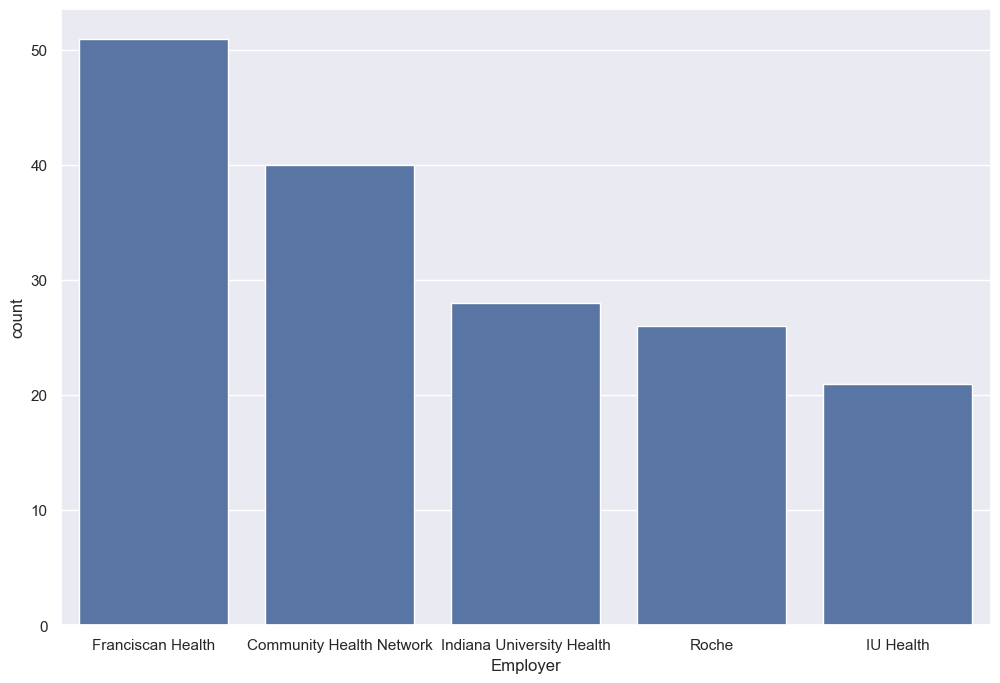

In [42]:
top_5_employers = clean["Employer"].value_counts().nlargest(5)
plt.figure(figsize = (12, 8))
sns.barplot(top_5_employers)

## Employer Industry

In [97]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

words = clean["Employer Industry"].dropna().tolist()
print(clean["Employer Industry"].unique().shape)

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(words)

kmeans = KMeans(n_clusters=45, random_state=0).fit(embeddings)

a = set()
for word, label in zip(words, kmeans.labels_):
    a.add(word)
    print(f"{word} → Cluster {label}")


/Users/jgonz/data_science_capstone/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(76,)
Science & Technology → Cluster 16
Sales and Marketing → Cluster 7
Healthcare → Cluster 1
Healthcare → Cluster 1
Healthcare → Cluster 1
Financial Services → Cluster 4
Business & Financial → Cluster 20
Financial Services → Cluster 4
Healthcare → Cluster 1
Healthcare → Cluster 1
Business & Financial → Cluster 20
Healthcare → Cluster 1
Religious Work → Cluster 34
Healthcare → Cluster 1
Healthcare → Cluster 1
Sports & Leisure → Cluster 6
Healthcare → Cluster 1
Healthcare → Cluster 1
Accounting → Cluster 28
Legal & Law Enforcement → Cluster 5
Healthcare → Cluster 1
Education, Training & Library → Cluster 8
Healthcare → Cluster 1
K-12 Education → Cluster 0
Sales and Marketing → Cluster 7
Other → Cluster 9
Business & Financial → Cluster 20
K-12 Education → Cluster 0
K-12 Education → Cluster 0
Healthcare → Cluster 1
CPG - Consumer Packaged Goods → Cluster 41
Sales and Marketing → Cluster 7
Construction → Cluster 18
K-12 Education → Cluster 0
Healthcare → Cluster 1
Healthcare → Cluster 1
H

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Employment Type

Employment Type
Full-Time    579
Part-Time     79
Name: count, dtype: int64


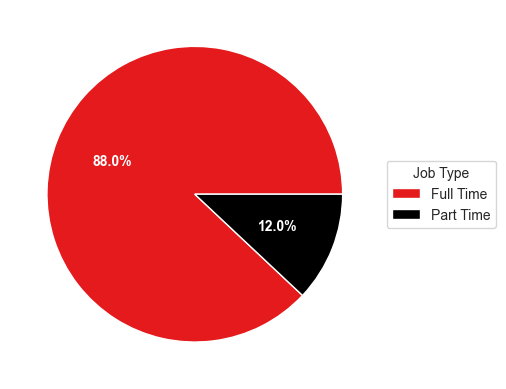

In [31]:
type = clean["Employment Type"].value_counts()
print(type)

wedges, texts, autotexts = plt.pie(type, colors=gen_palette, autopct="%1.1f%%")

for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")   # optional: make bold
    autotext.set_fontsize(10)

plt.legend(
    wedges,                # pie slices
    ["Full Time", "Part Time"],          # categories (F, M, N)
    title="Job Type",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)  # place legend outside
)
plt.show()


## Found through Handshake

In [ ]:
handshake = clean["Found through Handshake"].unique()
print(handshake)

Found through Handshake
Yes    18
Name: count, dtype: int64
1664


<Axes: xlabel='Found through Handshake', ylabel='count'>

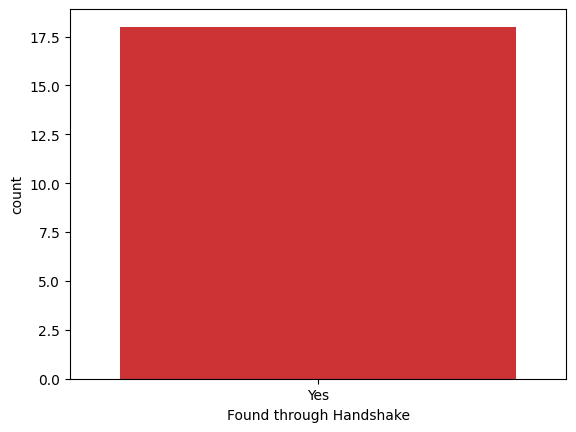

In [30]:
handshake_counts = clean["Found through Handshake"].value_counts()
print(handshake_counts)
print(clean["Found through Handshake"].isna().sum())
sns.barplot(handshake_counts)

## Salaries

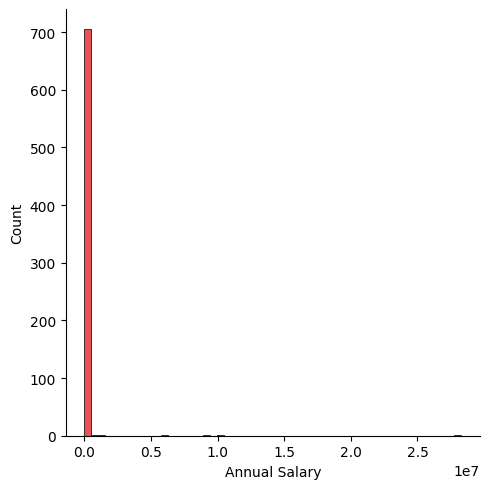

In [31]:
salaries = fds["Annual Salary"]
sns.displot(salaries, kind="hist")

<Axes: ylabel='Annual Salary'>

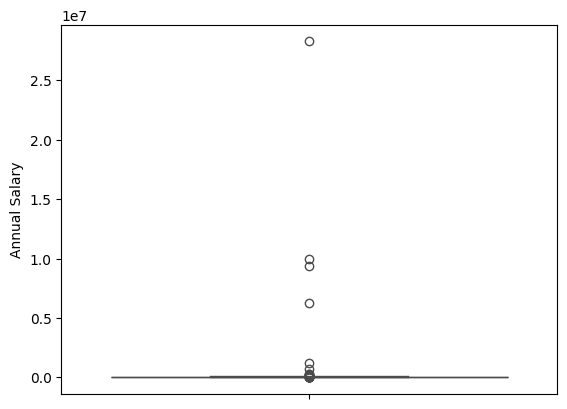

In [32]:
sns.boxplot(salaries)

### Removing outliers

In [33]:
q1 = salaries.quantile(0.25)
q3 = salaries.quantile(0.75)
iqr = q3 - q1
iqr

np.float64(25594.4)

In [34]:
salaries_no_outliers = salaries[(salaries >= q1 - 1.5 * iqr) & (salaries <= q3 + 1.5 * iqr)]
salaries_no_outliers

1       56000.0
3       50000.0
8       49000.0
13      55000.0
15      85000.0
         ...   
1666    42000.0
1674    27040.0
1676    37440.0
1678    66000.0
1681    41500.0
Name: Annual Salary, Length: 672, dtype: float64

In [35]:
salaries_no_outliers.describe()

count       672.000000
mean      51509.436161
std       18155.407298
min        2000.040000
25%       40000.000000
50%       51979.200000
75%       65000.000000
max      100000.000000
Name: Annual Salary, dtype: float64

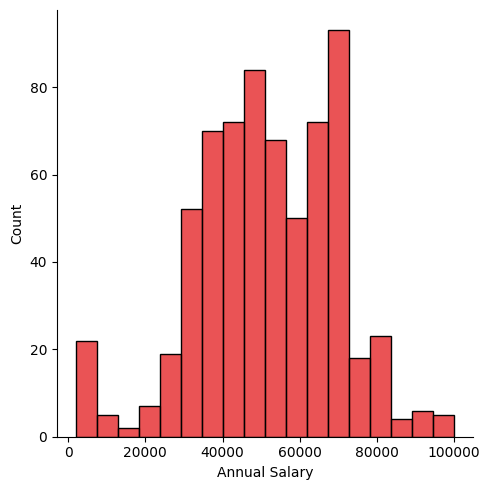

In [36]:
sns.displot(salaries_no_outliers, kind="hist")


<Axes: ylabel='Annual Salary'>

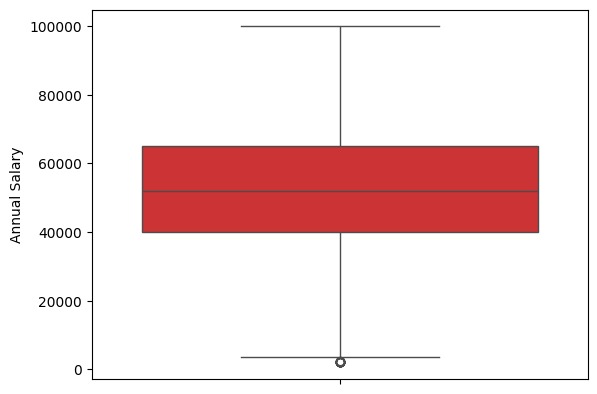

In [37]:
sns.boxplot(salaries_no_outliers)


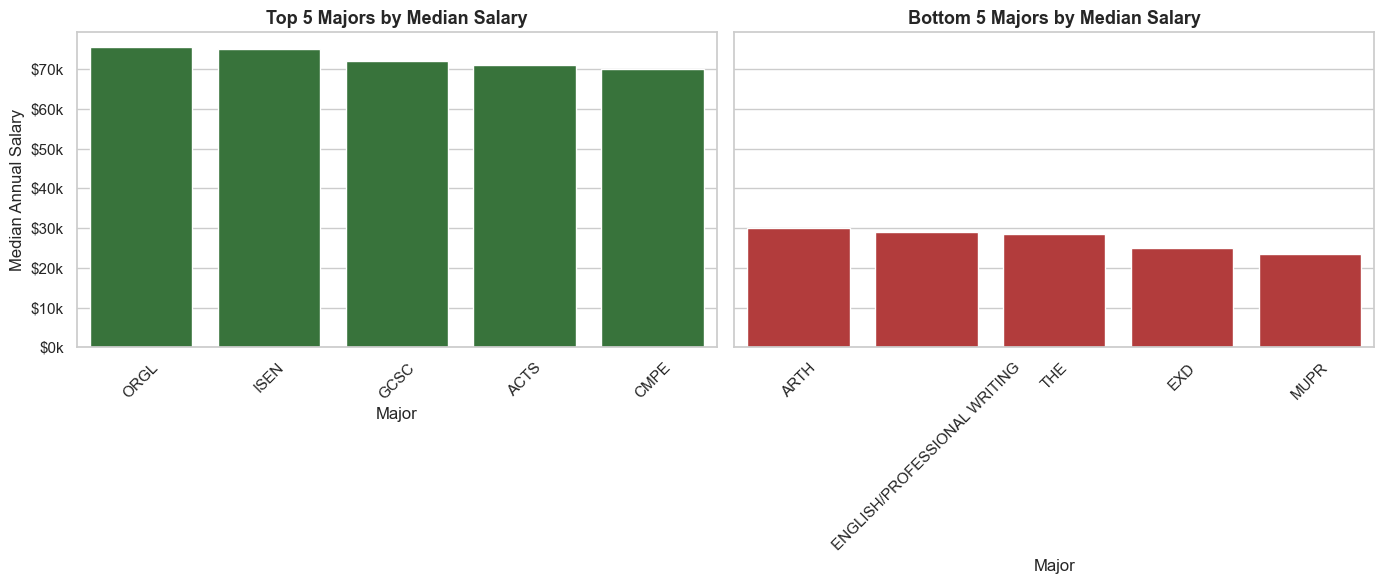

In [102]:
# --- Step 1: Prepare data ---
df = clean.dropna(subset=["Recipient Primary Major", "Annual Salary"]).copy()

# Convert salary to numeric (handles strings like "$45,000")
df["Annual Salary"] = (
    df["Annual Salary"]
    .astype(str)
    .replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# --- Step 2: Remove outliers using IQR ---
Q1 = df["Annual Salary"].quantile(0.25)
Q3 = df["Annual Salary"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df["Annual Salary"] >= lower_bound) & (df["Annual Salary"] <= upper_bound)]

# --- Step 3: Compute median salary per major ---
salary_by_major = (
    df_filtered.groupby("Recipient Primary Major")["Annual Salary"]
    .median()
    .reset_index()
    .sort_values(by="Annual Salary", ascending=False)
)

# --- Step 4: Select top 5 and bottom 5 ---
top5 = salary_by_major.head(5)
bottom5 = salary_by_major.tail(5)

# --- Step 5: Plot side-by-side ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Function for "$xxk" formatting ---
def k_formatter(x, pos):
    return f"${x/1000:.0f}k"

formatter = FuncFormatter(k_formatter)

# --- Plot 1: Top 5 majors (green) ---
sns.barplot(
    data=top5,
    x="Recipient Primary Major",
    y="Annual Salary",
    color="#2E7D32",  # dark green
    ax=axes[0]
)
axes[0].set_title("Top 5 Majors by Median Salary", fontsize=13, weight="bold")
axes[0].set_xlabel("Major")
axes[0].set_ylabel("Median Annual Salary")
axes[0].yaxis.set_major_formatter(formatter)
axes[0].tick_params(axis='x', rotation=45)

# --- Plot 2: Bottom 5 majors (red) ---
sns.barplot(
    data=bottom5,
    x="Recipient Primary Major",
    y="Annual Salary",
    color="#C62828",  # dark red
    ax=axes[1]
)
axes[1].set_title("Bottom 5 Majors by Median Salary", fontsize=13, weight="bold")
axes[1].set_xlabel("Major")
axes[1].set_ylabel("")
axes[1].yaxis.set_major_formatter(formatter)
axes[1].tick_params(axis='x', rotation=45)

# --- Final layout ---
plt.tight_layout()
plt.show()

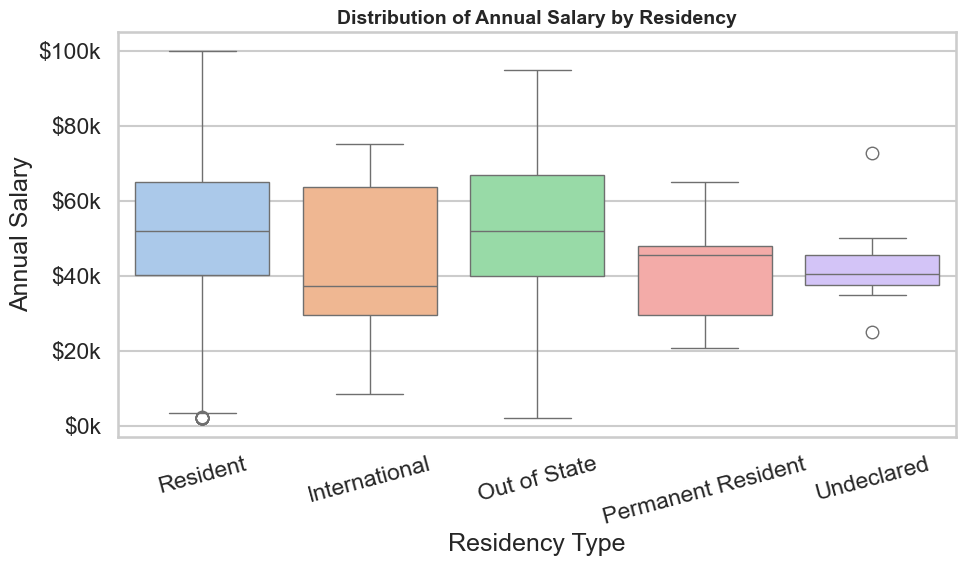

In [105]:
# --- Step 1: Prepare and clean data ---
df = clean.dropna(subset=["RESIDENCY", "Annual Salary"]).copy()

# Convert salary strings like "$45,000" → 45000
df["Annual Salary"] = (
    df["Annual Salary"]
    .astype(str)
    .replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# --- Step 2: Remove global outliers using IQR ---
Q1 = df["Annual Salary"].quantile(0.25)
Q3 = df["Annual Salary"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df["Annual Salary"] >= lower_bound) & (df["Annual Salary"] <= upper_bound)]

# --- Step 3: Plot ---
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_filtered,
    x="RESIDENCY",
    y="Annual Salary",
    hue="RESIDENCY",         # explicitly define hue
    palette="pastel",
    legend=False             # remove redundant legend
)

# Format y-axis as "$xxk"
def k_formatter(x, pos):
    return f"${x/1000:.0f}k"


class FuncFormatter:
    pass


plt.gca().yaxis.set_major_formatter(FuncFormatter(k_formatter))

plt.title("Distribution of Annual Salary by Residency", fontsize=14, weight="bold")
plt.xlabel("Residency Type")
plt.ylabel("Annual Salary")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


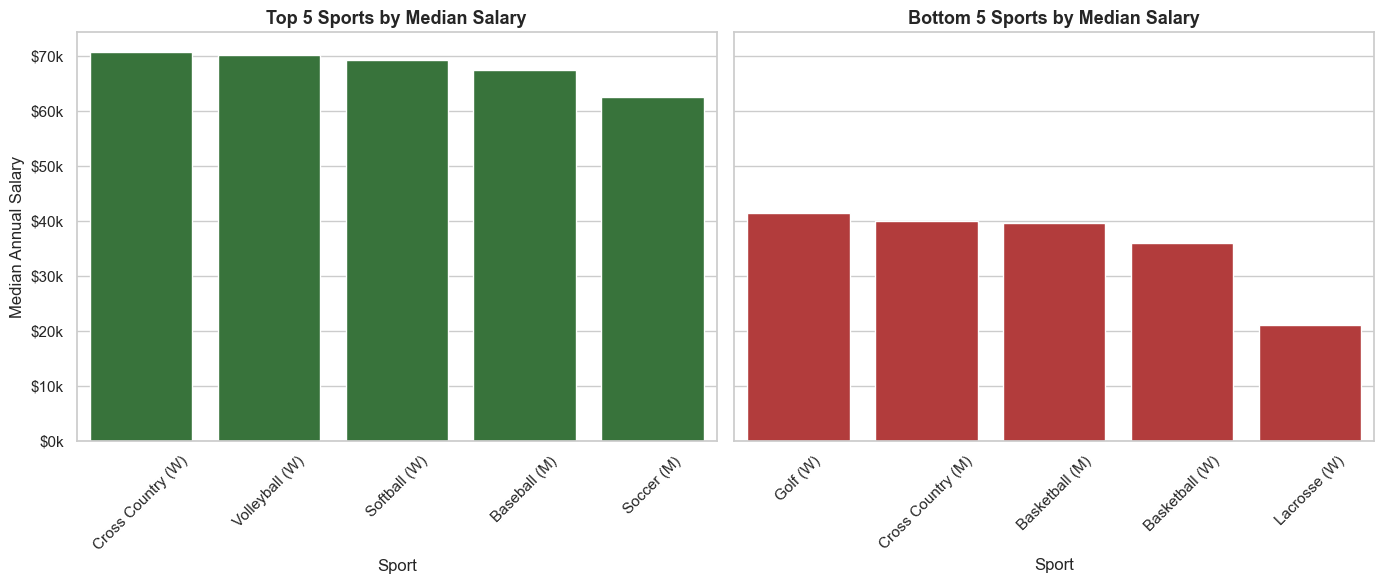

In [101]:
from matplotlib.ticker import FuncFormatter

# --- Step 1: Prepare data ---
df = clean.dropna(subset=["SPORT_1", "Annual Salary"]).copy()

# Convert salary to numeric (handles strings like "$45,000")
df["Annual Salary"] = (
    df["Annual Salary"]
    .astype(str)
    .replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# --- Step 2: Remove outliers using IQR ---
Q1 = df["Annual Salary"].quantile(0.25)
Q3 = df["Annual Salary"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df["Annual Salary"] >= lower_bound) & (df["Annual Salary"] <= upper_bound)]

# --- Step 3: Compute median salary per sport ---
salary_by_sport = (
    df_filtered.groupby("SPORT_1")["Annual Salary"]
    .median()
    .reset_index()
    .sort_values(by="Annual Salary", ascending=False)
)

# --- Step 4: Select top 5 and bottom 5 ---
top5 = salary_by_sport.head(5)
bottom5 = salary_by_sport.tail(5)

# --- Step 5: Create side-by-side subplots ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Function for "$xxk" formatting ---
def k_formatter(x, pos):
    return f"${x/1000:.0f}k"

formatter = FuncFormatter(k_formatter)

# --- Plot 1: Top 5 (single green color) ---
sns.barplot(
    data=top5,
    x="SPORT_1",
    y="Annual Salary",
    color="#2E7D32",   # dark green
    ax=axes[0]
)
axes[0].set_title("Top 5 Sports by Median Salary", fontsize=13, weight="bold")
axes[0].set_xlabel("Sport")
axes[0].set_ylabel("Median Annual Salary")
axes[0].yaxis.set_major_formatter(formatter)
axes[0].tick_params(axis='x', rotation=45)

# --- Plot 2: Bottom 5 (single red color) ---
sns.barplot(
    data=bottom5,
    x="SPORT_1",
    y="Annual Salary",
    color="#C62828",   # dark red
    ax=axes[1]
)
axes[1].set_title("Bottom 5 Sports by Median Salary", fontsize=13, weight="bold")
axes[1].set_xlabel("Sport")
axes[1].set_ylabel("")
axes[1].yaxis.set_major_formatter(formatter)
axes[1].tick_params(axis='x', rotation=45)

# --- Final layout ---
plt.tight_layout()
plt.show()


## FT/PT

FTPT
Full-Time    1493
Part-Time     189
Name: count, dtype: int64


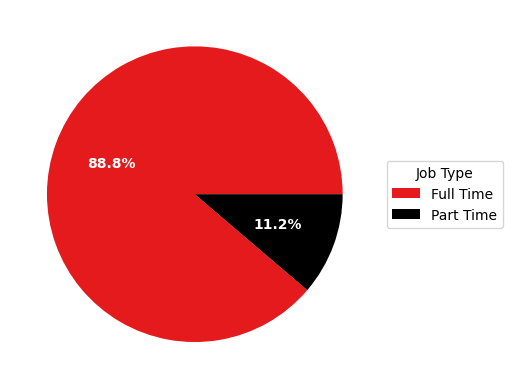

In [38]:
ft_pt_counts = clean["FTPT"].value_counts()
print(ft_pt_counts)

wedges, texts, autotexts = plt.pie(ft_pt_counts, colors=gen_palette, autopct="%1.1f%%")

for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")   # optional: make bold
    autotext.set_fontsize(10)

plt.legend(
    wedges,                # pie slices
    ["Full Time", "Part Time"],          # categories (F, M, N)
    title="Job Type",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)  # place legend outside
)
plt.show()

FTPT
Full-Time    724
Part-Time    131
Name: count, dtype: int64


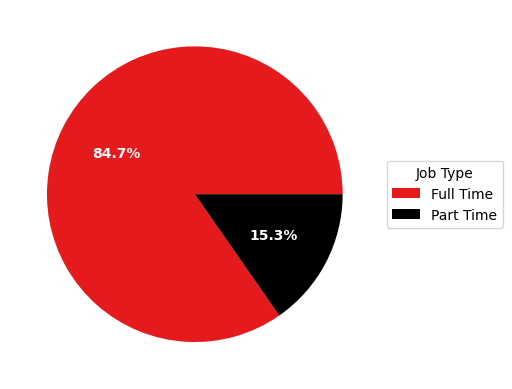

In [39]:
exclude = ["Still Looking", "Seeking employment", "Not Seeking", "Continuing Education", "Planning to further education but not yet enrolled", "Pursuing or furthering education (Graduate/Professional)"]
ft_pt_counts = clean[~clean["Outcome"].isin(exclude)]["FTPT"].value_counts()
print(ft_pt_counts)

wedges, texts, autotexts = plt.pie(ft_pt_counts, colors=gen_palette, autopct="%1.1f%%")

for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")   # optional: make bold
    autotext.set_fontsize(10)

plt.legend(
    wedges,                # pie slices
    ["Full Time", "Part Time"],          # categories (F, M, N)
    title="Job Type",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)  # place legend outside
)
plt.show()


## Sex

SEX
F    1098
M     581
N       3
Name: count, dtype: int64


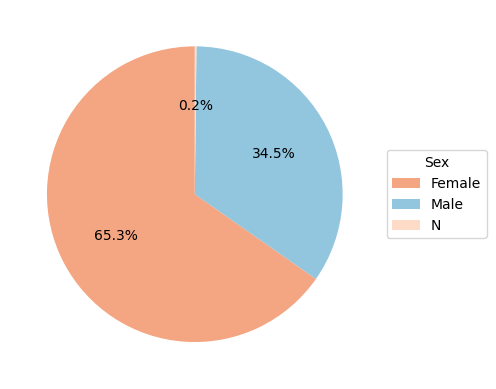

In [40]:
palette = {
    "F": "#f4a582",  # soft coral / red
    "M": "#92c5de",  # light blue
    "N": "#fddbc7"   # warm sandy yellow / neutral
}

sex_counts = clean["SEX"].dropna().value_counts()

print(sex_counts)
wedges, texts, autotexts = plt.pie(
    sex_counts,
    colors=[palette[g] for g in sex_counts.index],
    autopct="%1.1f%%",
    startangle=90
)

plt.legend(
    wedges,                # pie slices
    ["Female", "Male", "N"],          # categories (F, M, N)
    title="Sex",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)  # place legend outside
)

plt.show()

## Sports

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
1677    Track Indoor
1678             NaN
1679             NaN
1680             NaN
1681            Golf
Name: SPORT_1, Length: 1682, dtype: object


<Axes: xlabel='SPORT_1', ylabel='count'>

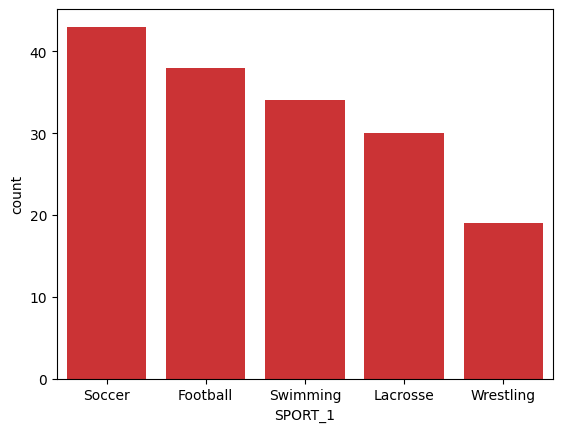

In [42]:
def remove_sex(sport):
    if pd.isna(sport):
        return sport
    sport = sport.split("(")[0].strip()
    return sport

sports = clean["SPORT_1"].map(remove_sex)
print(sports)
top_5_sports = sports.dropna().value_counts().nlargest(5)
sns.barplot(top_5_sports)

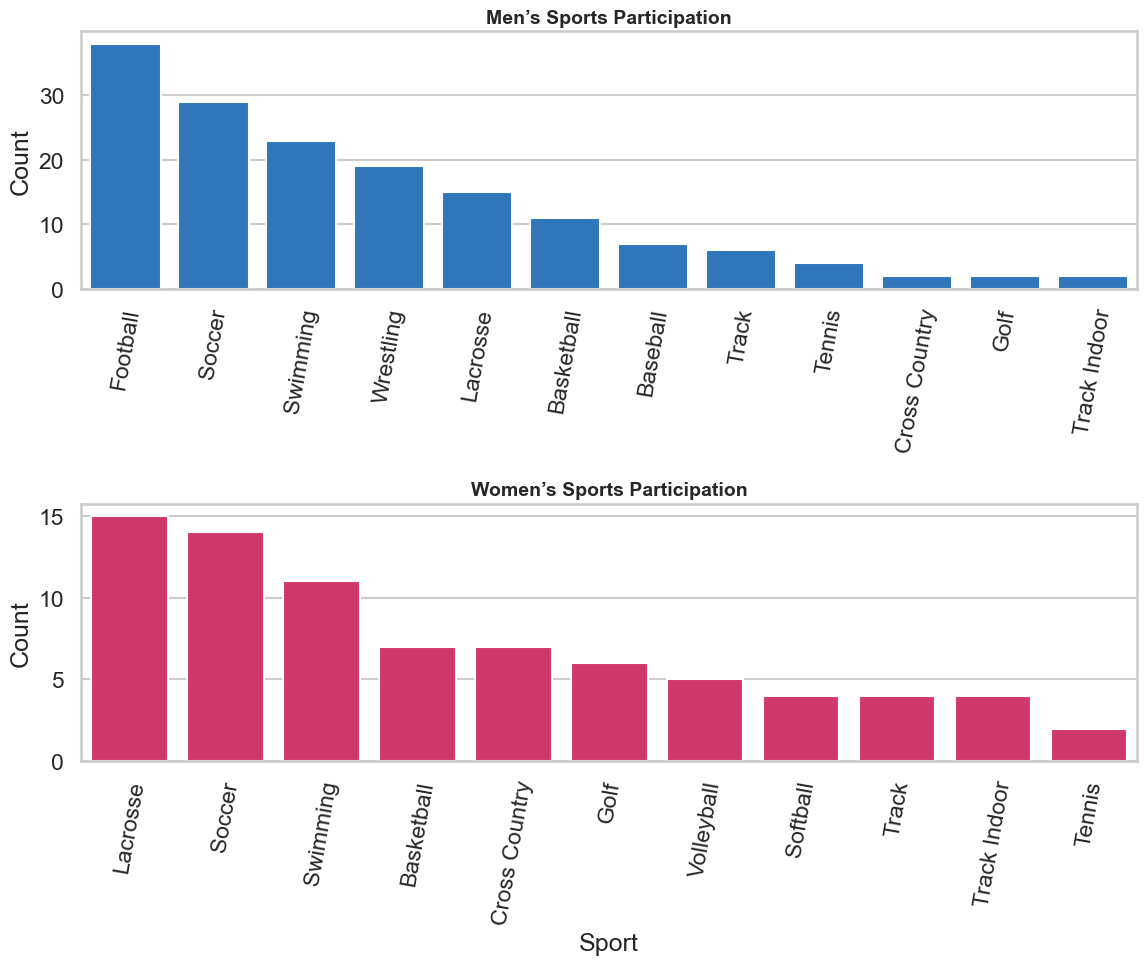

In [111]:
# --- Step 1: Prepare and clean data ---
df = clean.dropna(subset=["SPORT_1"]).copy()

# Extract gender (M/W) and clean sport names
df["Gender"] = df["SPORT_1"].str.extract(r"\((M|W)\)")
df["Sport"] = df["SPORT_1"].str.replace(r"\s*\(.*\)", "", regex=True).str.strip()

# --- Step 2: Count participants by sport and gender ---
sport_counts = (
    df.groupby(["Sport", "Gender"])
    .size()
    .reset_index(name="Count")
)

# --- Step 3: Separate and sort ---
men = sport_counts[sport_counts["Gender"] == "M"].sort_values("Count", ascending=False)
women = sport_counts[sport_counts["Gender"] == "W"].sort_values("Count", ascending=False)

# --- Step 4: Plot ---
sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Men's sports
sns.barplot(
    data=men,
    x="Sport",
    y="Count",
    color="#1976D2",
    order=men["Sport"],  # sorted order specific to men
    ax=axes[0],
)
axes[0].set_title("Men’s Sports Participation", fontsize=14, weight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=80)

# Women’s sports
sns.barplot(
    data=women,
    x="Sport",
    y="Count",
    color="#E91E63",
    order=women["Sport"],  # sorted order specific to women
    ax=axes[1],
)
axes[1].set_title("Women’s Sports Participation", fontsize=14, weight="bold")
axes[1].set_xlabel("Sport")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=80)

plt.tight_layout()
plt.show()


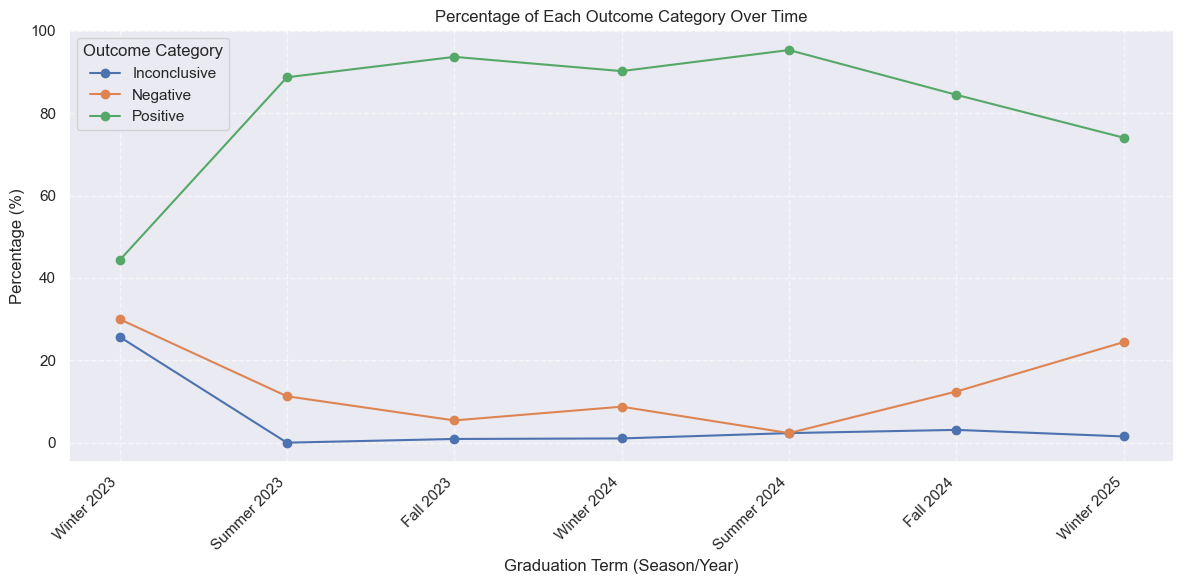

In [48]:
# --- STEP 1: Extract season and year ---
clean["Season"] = clean["Recipient Graduation Date"].str.split().str[0]
clean["Year"] = (
    clean["Recipient Graduation Date"]
    .str.split()
    .str[1]
    .apply(lambda x: int(x) if pd.notna(x) else None)
)

# --- STEP 2: Order the seasons numerically ---
season_order = {"Winter": 1, "Spring": 2, "Summer": 3, "Fall": 4}
clean["SeasonOrder"] = clean["Season"].map(season_order)

# --- STEP 3: Drop invalid rows ---
clean = clean.dropna(subset=["Year", "SeasonOrder"])

# --- STEP 4: Combine into sortable numeric key (year + fractional season) ---
clean["YearSeason"] = clean["Year"] + clean["SeasonOrder"] / 10.0

# --- STEP 5: Filter data up to Winter 2025 ---
clean = clean[clean["YearSeason"] <= 2025.1]

# --- STEP 6: Count and compute percentages per category over time ---
counts = clean.groupby(["YearSeason", "Outcome Category"]).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# --- STEP 7: Create readable x-axis labels ---
def label_for(value):
    year = int(value)
    season_num = int(round((value - year) * 10))
    season = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}.get(season_num, "")
    return f"{season} {year}"

labels = [label_for(v) for v in percentages.index]

# --- STEP 8: Assign evenly spaced x-values ---
x_positions = np.arange(len(percentages.index))

# --- STEP 9: Plot all categories together ---
plt.figure(figsize=(12, 6))
for cat in percentages.columns:
    plt.plot(x_positions, percentages[cat], marker="o", label=cat)

plt.title("Percentage of Each Outcome Category Over Time")
plt.xlabel("Graduation Term (Season/Year)")
plt.ylabel("Percentage (%)")

# Evenly spaced ticks with Season + Year labels
plt.xticks(x_positions, labels, rotation=45, ha="right")

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Outcome Category")
plt.tight_layout()
plt.show()


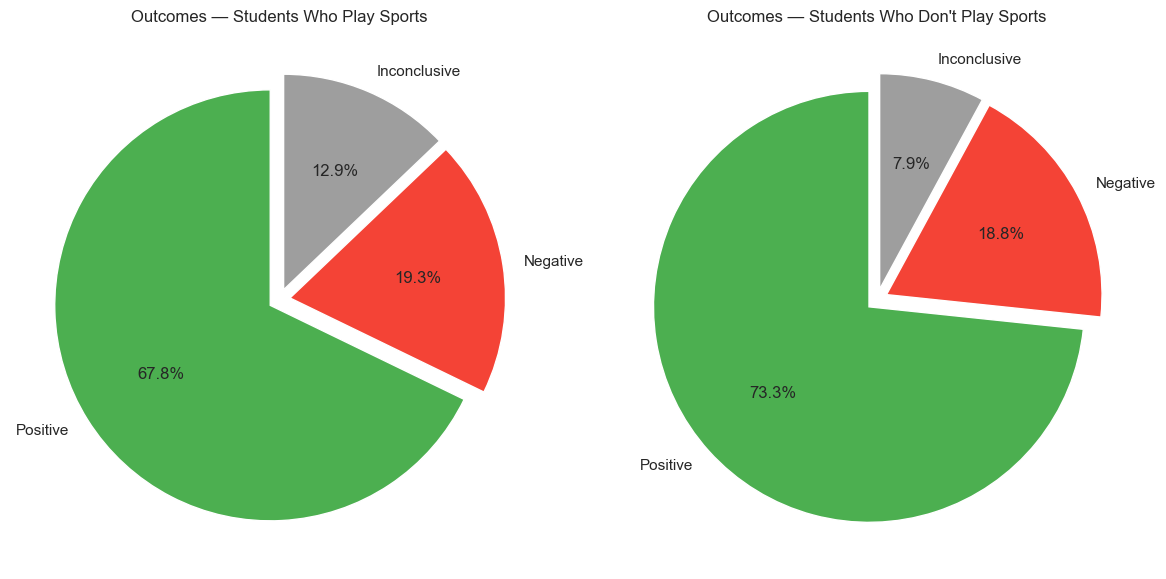

In [49]:
# --- Step 1: Categorize outcomes ---
def categorize_outcome(o):
    if pd.isna(o):
        return None
    o = str(o).lower()
    if o in ["still looking", "seeking employment"]:
        return "Negative"
    elif "pursuing or furthering education" in o or o == "not seeking":
        return "Inconclusive"
    else:
        return "Positive"

# --- Step 2: Prepare data ---
df = clean.copy()
df["Outcome Category"] = df["Outcome"].apply(categorize_outcome)

# --- Step 3: Split by sports participation ---
sports_df = df[df["SPORT_1"].notna()].copy()
no_sports_df = df[df["SPORT_1"].isna()].copy()

# --- Step 4: Count outcomes ---
sports_counts = sports_df["Outcome Category"].value_counts().reindex(["Positive", "Negative", "Inconclusive"], fill_value=0)
no_sports_counts = no_sports_df["Outcome Category"].value_counts().reindex(["Positive", "Negative", "Inconclusive"], fill_value=0)

# --- Step 5: Plot side-by-side pie charts ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#4CAF50", "#F44336", "#9E9E9E"]  # Positive / Negative / Inconclusive

# Pie 1: Students who play sports
axes[0].pie(
    sports_counts,
    labels=sports_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=[0.05]*3
)
axes[0].set_title("Outcomes — Students Who Play Sports")

# Pie 2: Students who don't play sports
axes[1].pie(
    no_sports_counts,
    labels=no_sports_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=[0.05]*3
)
axes[1].set_title("Outcomes — Students Who Don't Play Sports")

plt.tight_layout()
plt.show()


In [58]:
list(clean.columns)

['Random Identifier',
 'Recipient Primary Major',
 'Recipient Secondary Majors',
 'Recipient Graduation Date',
 'Recipient Primary College',
 'Recipient Graduation Group Name',
 'Response Date',
 'Outcome',
 'Employer Name',
 'Employer Industry',
 'Employment Type',
 'Job Function',
 'Job Position',
 'Found through Handshake',
 'Employed During Education',
 'Internship',
 'Continuing Education School',
 'Continuing Education Level',
 'Continuing Education Major',
 'Still Looking Option',
 'Not Seeking Option',
 'Location',
 'Offer Date',
 'Accept Date',
 'Start Date',
 'Annual Salary',
 'Pay Schedule',
 'Bonus Amount',
 'Other Compensation',
 'Knowledge Response?',
 '922242: Did you participate in a Work Based Experience while attending UIndy?',
 '922243: Please list the name of the employer(s) / organization(s) for which you participated in Experiential Learning.  (Skip this question if you answered "None of the Above" to the previous question.)',
 '922244: Do you feel like the Profes

## Model

🌲 Random Forest Regression Summary 🌲
------------------------------------
R² Score: -52.065
Mean Absolute Error: $42,938.41
Training samples: 568, Testing samples: 143


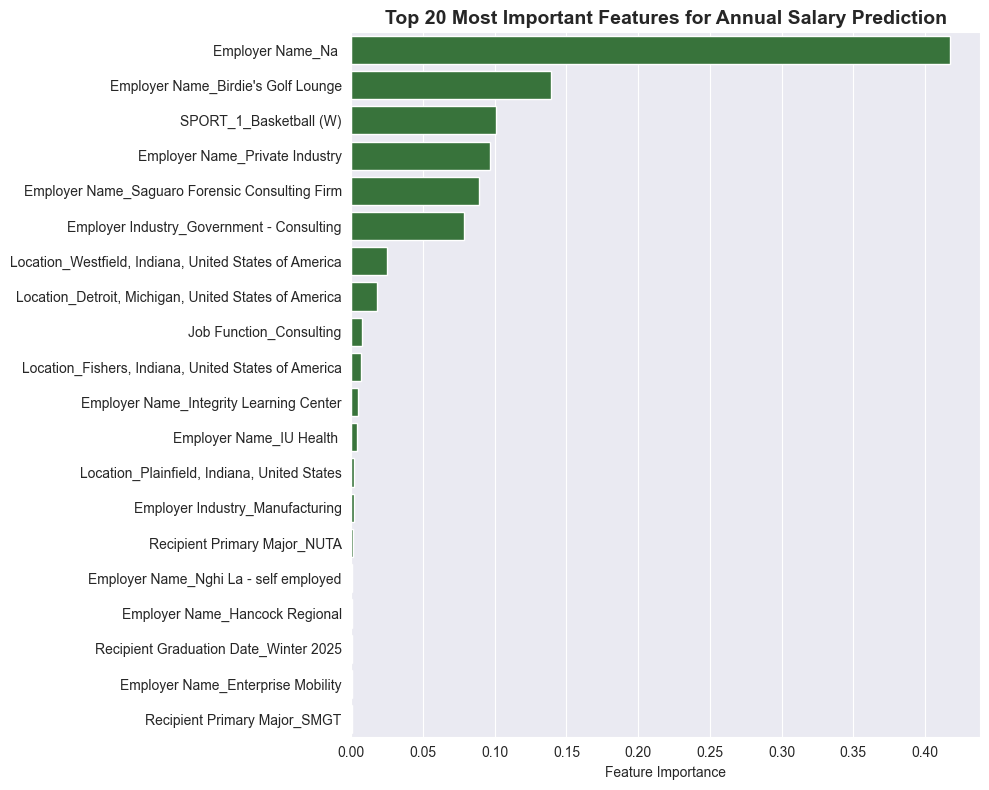

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define features and target ---
features = [
    "Recipient Primary Major",
    "Recipient Graduation Date",
    "Outcome",
    "Employer Name",
    "Employer Industry",
    "Job Function",
    "Location",
    "FTPT",
    "RESIDENCY",
    "SEX",
    "SPORT_1"
]
target = "Annual Salary"

# --- Step 2: Drop rows with missing target ---
df_model = clean.dropna(subset=[target]).copy()

X = df_model[features]
y = df_model[target]

# --- Step 3: Preprocessing (handle missing categorical values) ---
cat_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

# --- Step 4: Model ---
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", rf)
])

# --- Step 5: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 6: Train model ---
model.fit(X_train, y_train)

# --- Step 7: Evaluate model ---
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("🌲 Random Forest Regression Summary 🌲")
print("------------------------------------")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# --- Step 8: Feature Importance ---
onehot = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
feature_names = onehot.get_feature_names_out(cat_features)
importances = model.named_steps["regressor"].feature_importances_

importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
    .head(20)
)

# --- Step 9: Plot Feature Importance ---
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df,
    x="Importance",
    y="Feature",
    color="#2E7D32"
)
plt.title("Top 20 Most Important Features for Annual Salary Prediction", fontsize=14, weight="bold")
plt.xlabel("Feature Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()


🎯 Random Forest Classification Summary 🎯
-----------------------------------------
                                                                     precision    recall  f1-score   support

                                               Continuing Education       0.99      0.99      0.99        75
          Employed full time (on average 30 hours or more per week)       0.81      1.00      0.89        25
        Employed part time (on average less than 30 hours per week)       0.00      0.00      0.00         6
                                                           Military       0.00      0.00      0.00         1
                                                        Not Seeking       0.50      0.20      0.29         5
Participating in a volunteer or service program (e.g., Peace Corps)       0.00      0.00      0.00         0
                 Planning to further education but not yet enrolled       0.00      0.00      0.00         9
           Pursuing or furthering education 

/Users/jgonz/data_science_capstone/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jgonz/data_science_capstone/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jgonz/data_science_capstone/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

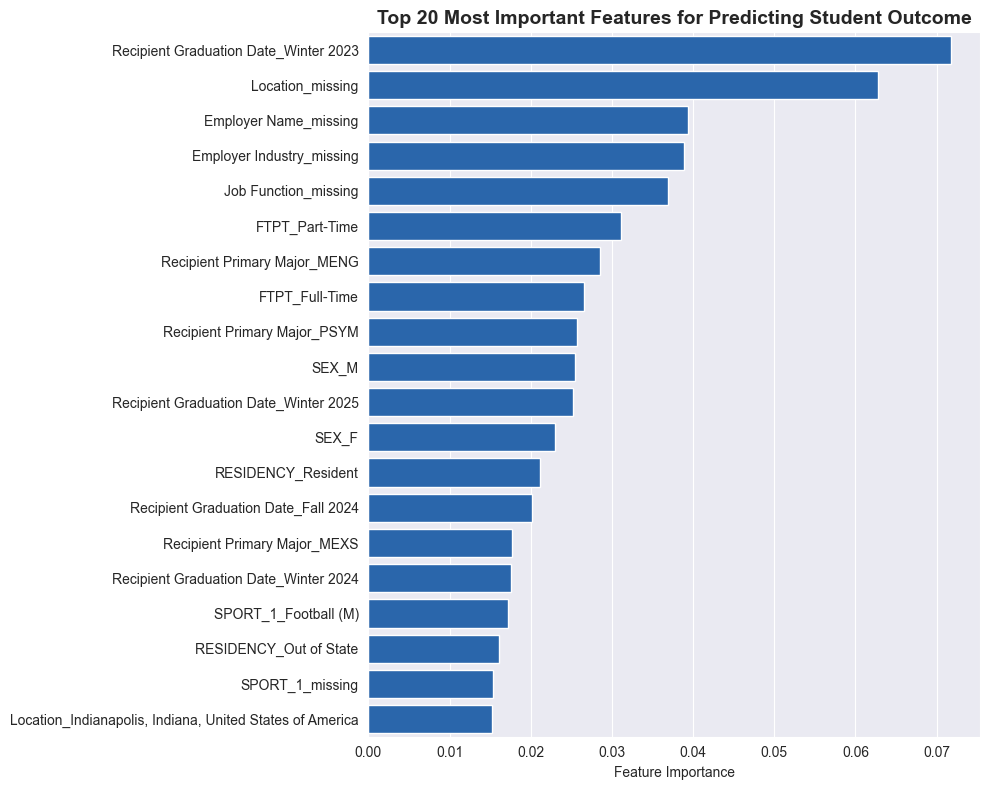

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define features and target ---
features = [
    "Recipient Primary Major",
    "Recipient Graduation Date",
    "Employer Name",
    "Employer Industry",
    "Job Function",
    "Location",
    "FTPT",
    "RESIDENCY",
    "SEX",
    "SPORT_1"
]
target = "Outcome"

# --- Step 2: Drop rows with missing Outcome ---
df_model = clean.dropna(subset=[target]).copy()

X = df_model[features]
y = df_model[target].astype(str).str.strip()

# --- Step 3: Handle missing categorical values ---
cat_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

# --- Step 4: Random Forest Classifier ---
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",  # handles class imbalance
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf)
])

# --- Step 5: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Step 6: Train model ---
model.fit(X_train, y_train)

# --- Step 7: Evaluate model ---
y_pred = model.predict(X_test)

print("🎯 Random Forest Classification Summary 🎯")
print("-----------------------------------------")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- Step 8: Feature Importance ---
onehot = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
feature_names = onehot.get_feature_names_out(cat_features)
importances = model.named_steps["classifier"].feature_importances_

importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
    .head(20)
)

# --- Step 9: Plot Feature Importance ---
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df,
    x="Importance",
    y="Feature",
    color="#1565C0"
)
plt.title("Top 20 Most Important Features for Predicting Student Outcome", fontsize=14, weight="bold")
plt.xlabel("Feature Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()
